### Assignment A.2: Clustering and Classification
#### Author - Rashmi Patel

### Introduction
<p>Clustering is an unsupervised learning technique used to group similar data points together without predefined labels. In NLP, clustering is used to group similar text documents or sentences based on their content or meaning.Classification is a supervised learning technique where the goal is to predict a category or label for new data based on pre-labeled training data.</p>

### Loading Libraries

In [4]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import spacy
from docx import Document
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
nlp = spacy.load("en_core_web_sm")

### Data Path for Movie Reviews

In [6]:
# Step 1: Define a function to read the text from .docx files
def read_docx_file(file_path):
    doc = Document(file_path)
    full_text = []
    for paragraph in doc.paragraphs:
        full_text.append(paragraph.text)
    return "\n".join(full_text)

# Step 2: Specify the folder containing the Word documents
folder_path = r'C:\Users\Raspatel\Downloads\NLP Assignment two\Movie Review'

# Step 3: Read all .docx files from the folder
documents = []
filenames = []
for filename in os.listdir(folder_path):
    if filename.endswith(".docx"):
        file_path = os.path.join(folder_path, filename)
        text = read_docx_file(file_path)
        documents.append(text)
        filenames.append(filename)

### Preprocessing

In [8]:
# Preprocessing function
def preprocess_text(text):
    # Remove special characters, digits, and URLs
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URL

    # Remove 'br' tags explicitly
    text = text.replace('br', '')
    
    # Process with spaCy
    doc = nlp(text)
    
    # Lemmatize and remove stop words
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    
    return ' '.join(tokens)

# Preprocess all reviews
preprocessed_reviews = [preprocess_text(review) for review in documents]

# Create TF-IDF Vectorizer (Focus on important terms like genre)
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1, 2), max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_reviews)

# Normalize the TF-IDF matrix
tfidf_matrix_normalized = normalize(tfidf_matrix, norm='l2', axis=1)

# Preprocess all reviews
preprocessed_reviews = [preprocess_text(review) for review in documents]

# Create TF-IDF Vectorizer (Focus on important terms like genre)
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1, 2), max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_reviews)

# Normalize the TF-IDF matrix
tfidf_matrix_normalized = normalize(tfidf_matrix, norm='l2', axis=1)

### Optimum Number of Clusters
Insight-The plot helps identify the "elbow point" where the inertia starts to decrease more slowly. This point indicates that increasing the number of clusters beyond this point doesn’t significantly improve the model's performance. The Elbow Method provides a practical guideline for choosing an appropriate number of clusters, typically when the rate of inertia reduction levels off.The highest silhouette score represents the most cohesive and well-separated clusters.
The optimal number of clusters corresponds to the k with the highest silhouette score, indicating the best overall clustering structure. The Silhouette Score is valuable for evaluating the consistency and separation of clusters. Higher scores reflect more distinct clusters with better-defined boundaries.


In [10]:

# Function to analyze optimal clusters using Elbow and Silhouette
def analyze_clusters(tfidf_matrix, max_clusters=10):
    """Analyze optimal number of clusters using multiple methods"""
    K = range(2, max_clusters + 1)
    inertias = []
    silhouette_scores = []
    
    for k in K:
        print(f"Testing k={k}...")
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(tfidf_matrix)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(tfidf_matrix, kmeans.labels_))
    
    # Calculate the rate of change for elbow method
    inertia_changes = np.diff(inertias)
    relative_changes = np.abs(inertia_changes / inertias[:-1])
    
    # Find the elbow point (where the rate of change starts to level off)
    elbow_idx = np.argmin(relative_changes) + 2
    
    # Find the best silhouette score
    best_silhouette_idx = np.argmax(silhouette_scores) + 2
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Elbow curve
    ax1.plot(K, inertias, 'bx-')
    ax1.axvline(x=elbow_idx, color='r', linestyle='--', 
                label=f'Elbow at k={elbow_idx}')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method Analysis')
    ax1.legend()
    ax1.grid(True)
    
    # Silhouette curve
    ax2.plot(K, silhouette_scores, 'rx-')
    ax2.axvline(x=best_silhouette_idx, color='b', linestyle='--',
                label=f'Best at k={best_silhouette_idx}')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\nCluster Analysis Results:")
    print(f"Elbow Method suggests {elbow_idx} clusters")
    print(f"Silhouette Analysis suggests {best_silhouette_idx} clusters")
    print(f"\nSilhouette Scores:")
    for k, score in zip(K, silhouette_scores):
        print(f"k={k}: {score:.3f}")
    
    return elbow_idx, best_silhouette_idx, silhouette_scores



### Word Clouds For Each Cluster

In [12]:
# Create word clouds for each cluster
def create_wordclouds_per_cluster(kmeans_labels, tfidf_matrix, vectorizer, n_clusters=8):
    """Create word clouds for each cluster"""
    terms = vectorizer.get_feature_names_out()
    for i in range(n_clusters):
        cluster_terms = np.mean(tfidf_matrix[kmeans_labels == i], axis=0)
        cluster_words = {terms[j]: cluster_terms[0, j] for j in range(len(terms))}
        
        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(cluster_words)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for Cluster {i}")
        plt.show()


### HeatMap Showing Cosine Similarity Between Documents
Insight: Heatmaps can help you visually inspect patterns in the data.
High correlation or similarity between documents will appear as darker regions on the heatmap (depending on the color scheme), indicating that documents within a cluster are highly similar.
Differences between clusters can be shown by lighter or less intense regions, suggesting that documents in different clusters are less similar to each other. A heatmap can visually show the density and spread of clusters. Tight, well-defined clusters will appear as strong, distinct blocks in the heatmap, while weak or overlapping clusters may be more diffuse.


In [14]:
# Plot a heatmap showing cosine similarity between documents
def plot_cosine_similarity_heatmap(tfidf_matrix):
    cosine_sim = cosine_similarity(tfidf_matrix)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cosine_sim, cmap='coolwarm')
    plt.title('Cosine Similarity Heatmap Between Documents')
    plt.show()


### 2D Visualization of Cluster
Insight: This visualization shows how well-separated the clusters are in reduced dimensions.
If the points of different clusters are well-separated, it indicates that the clustering algorithm has successfully grouped similar documents together.
Overlapping points from different clusters could indicate some ambiguity in classification or that more clusters are needed. PCA helps visualize the separation of high-dimensional text data, offering a clearer view of how distinct the clusters are in a reduced feature space.


In [16]:
# 2D PCA visualization of clusters
def plot_2d_visualization(tfidf_matrix, kmeans_labels):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(tfidf_matrix.toarray())
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='rainbow', s=50)
    plt.title('2D PCA Visualization of Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()



### 2D t-SNE Projection of TD-IDF Vectors
Insight: The t-SNE plot gives a more detailed picture of how tightly grouped the clusters are and how close some clusters are to one another. Tightly packed clusters suggest strong separation and consistency in the data. Intermingled clusters might indicate overlap in themes or topics within the dataset.t-SNE is particularly useful for visualizing non-linear relationships and structure in the data, offering insights into how well the clustering model has captured the document similarities.

In [18]:
# 2D t-SNE projection of the TF-IDF vectors
def plot_tsne_projection(tfidf_matrix, kmeans_labels):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_data = tsne.fit_transform(tfidf_matrix.toarray())
    
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=kmeans_labels, cmap='rainbow', s=50)
    plt.title('2D t-SNE Projection of TF-IDF Vectors')
    plt.show()

### 3D PCA Visualization 

In [20]:
# 3D PCA visualization of the clusters
def plot_3d_pca_visualization(tfidf_matrix, kmeans_labels):
    pca = PCA(n_components=3)
    reduced_data = pca.fit_transform(tfidf_matrix.toarray())
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=kmeans_labels, cmap='rainbow', s=50)
    
    ax.set_title('3D PCA Visualization of Clusters')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    plt.show()

Analyzing optimal number of clusters...
Testing k=2...
Testing k=3...
Testing k=4...
Testing k=5...
Testing k=6...
Testing k=7...
Testing k=8...
Testing k=9...
Testing k=10...


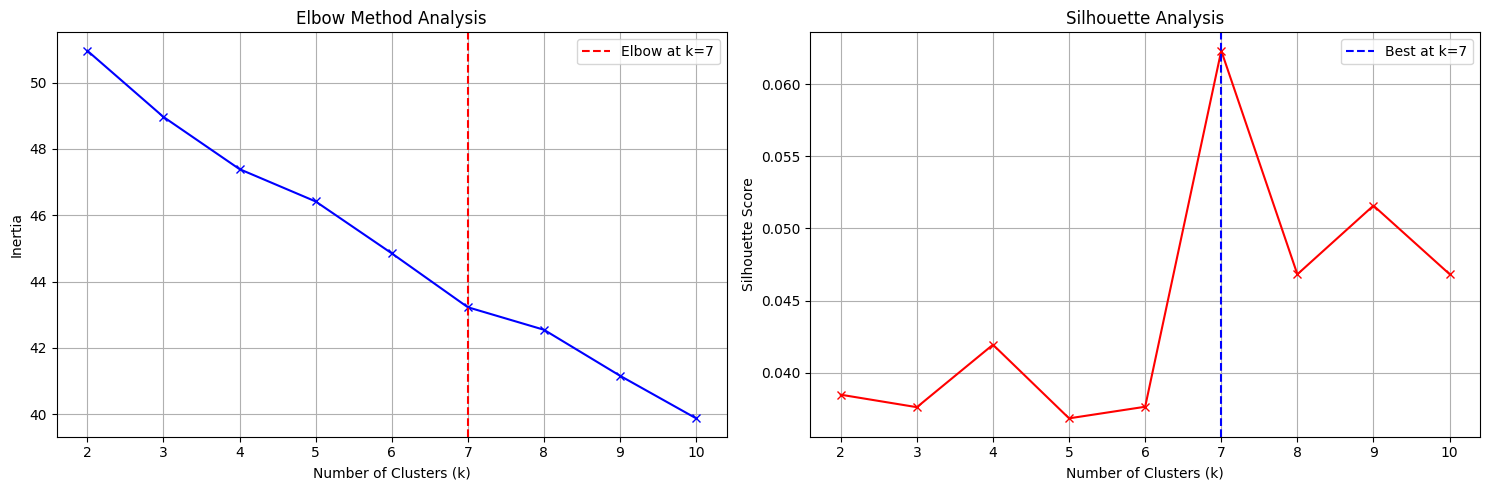


Cluster Analysis Results:
Elbow Method suggests 7 clusters
Silhouette Analysis suggests 7 clusters

Silhouette Scores:
k=2: 0.038
k=3: 0.038
k=4: 0.042
k=5: 0.037
k=6: 0.038
k=7: 0.062
k=8: 0.047
k=9: 0.052
k=10: 0.047

Final Recommendation:
Based on both Elbow and Silhouette analysis, 7 clusters would be optimal.
Clustering documents into 8 clusters...
Generating word clouds for each cluster...


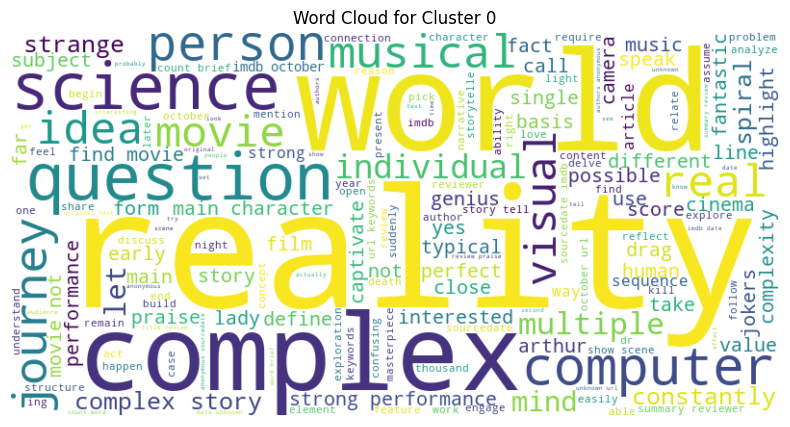

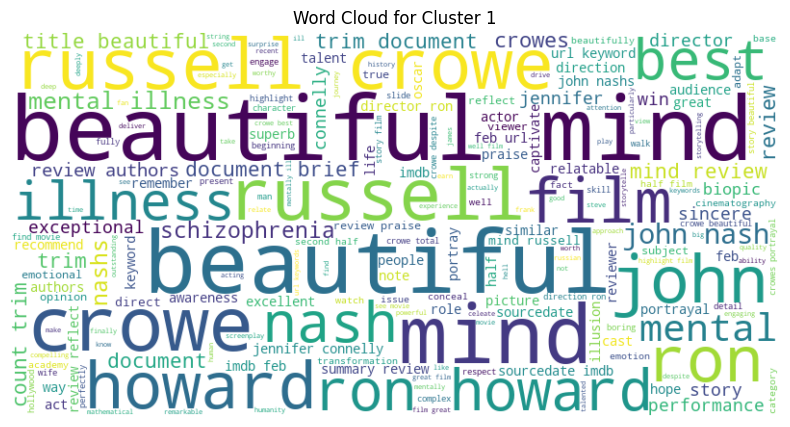

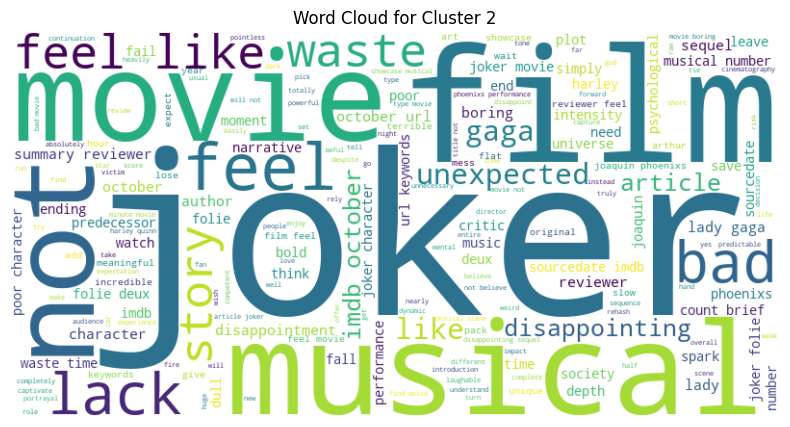

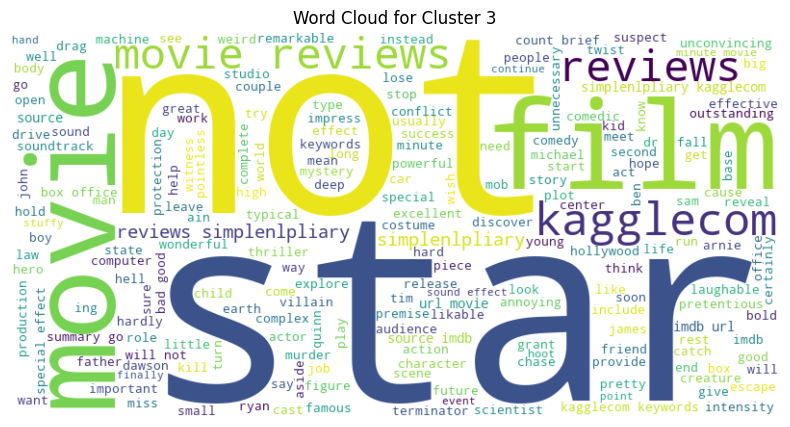

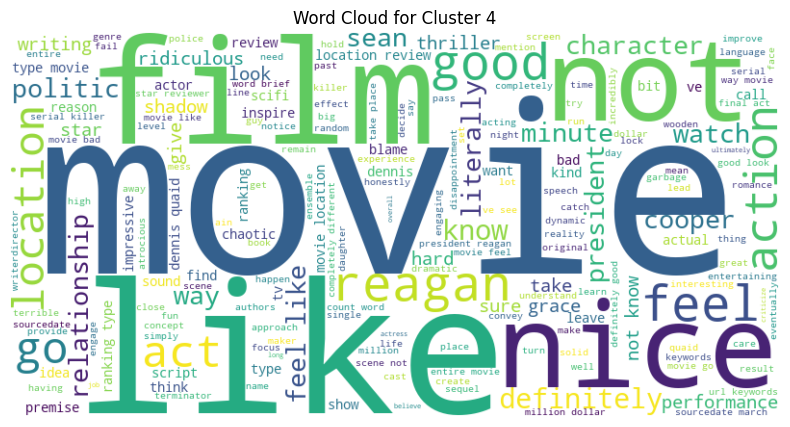

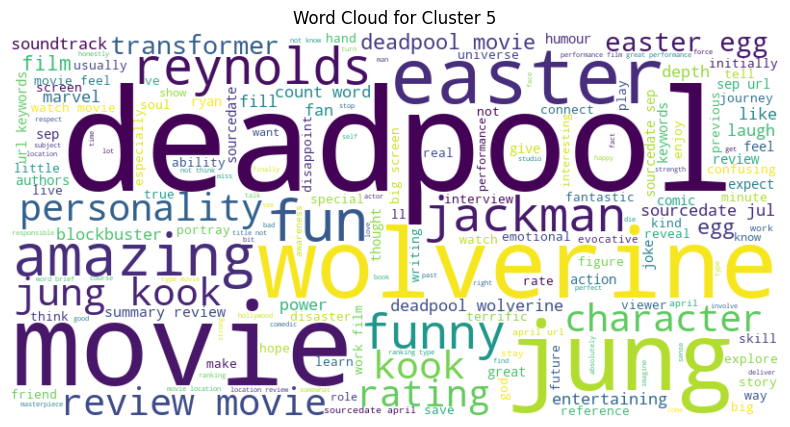

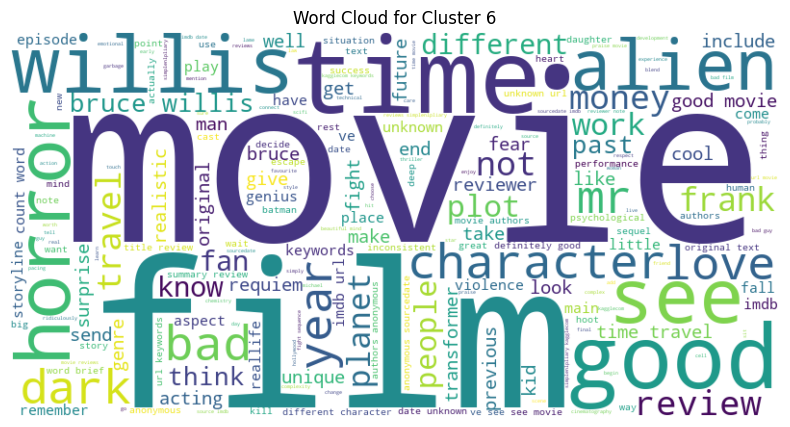

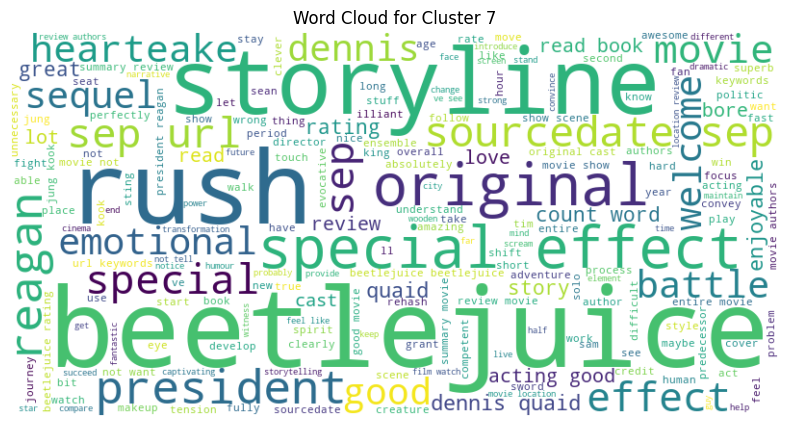

Plotting cosine similarity heatmap...


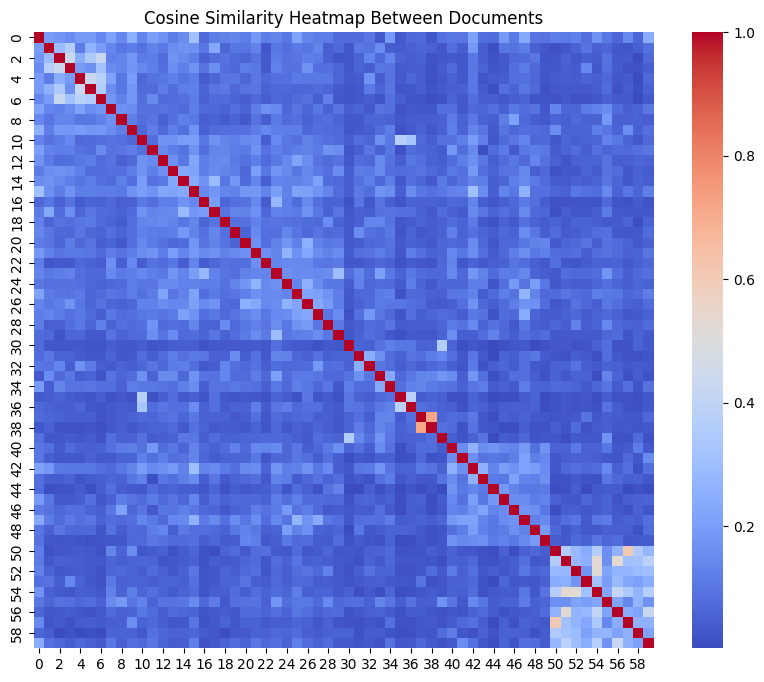

2D PCA visualization...


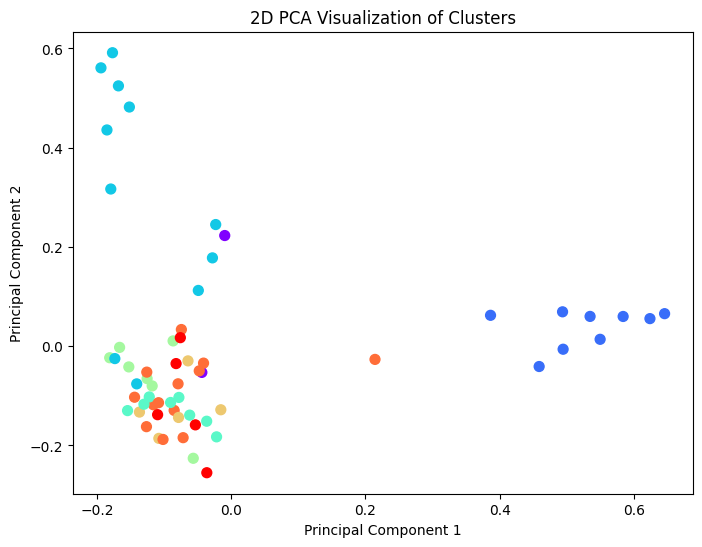

2D t-SNE projection...


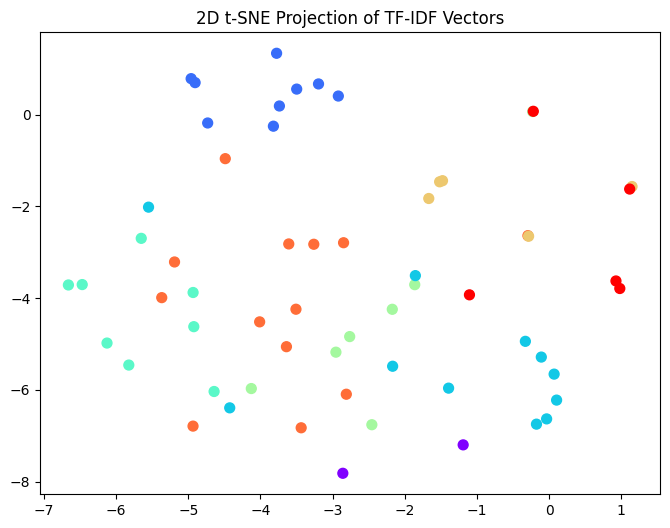

3D PCA visualization...


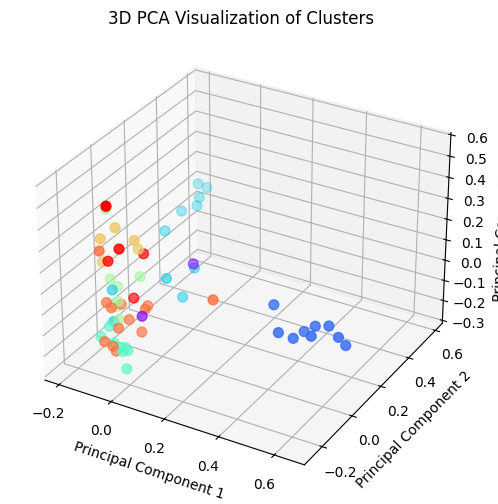

In [21]:
def main():
    # Analyze clusters
    print("Analyzing optimal number of clusters...")
    elbow_k, silhouette_k, silhouette_scores = analyze_clusters(tfidf_matrix_normalized)
    
    # Make recommendation
    avg_k = (elbow_k + silhouette_k) // 2
    print("\nFinal Recommendation:")
    print(f"Based on both Elbow and Silhouette analysis, {avg_k} clusters would be optimal.")
    
    # Apply KMeans clustering with 8 clusters
    print("Clustering documents into 8 clusters...")
    kmeans = KMeans(n_clusters=8, random_state=42)
    kmeans_labels = kmeans.fit_predict(tfidf_matrix_normalized)
    
    # Visualize word clouds for each cluster
    print("Generating word clouds for each cluster...")
    create_wordclouds_per_cluster(kmeans_labels, tfidf_matrix, tfidf_vectorizer, n_clusters=8)
    
    # Cosine similarity heatmap
    print("Plotting cosine similarity heatmap...")
    plot_cosine_similarity_heatmap(tfidf_matrix_normalized)
    
    # 2D PCA visualization of clusters
    print("2D PCA visualization...")
    plot_2d_visualization(tfidf_matrix, kmeans_labels)
    
    # 2D t-SNE projection
    print("2D t-SNE projection...")
    plot_tsne_projection(tfidf_matrix, kmeans_labels)
    
    # 3D PCA visualization of clusters
    print("3D PCA visualization...")
    plot_3d_pca_visualization(tfidf_matrix, kmeans_labels)

if __name__ == "__main__":
    main()


### Clustering by Genre

### Code with Unknown Genre

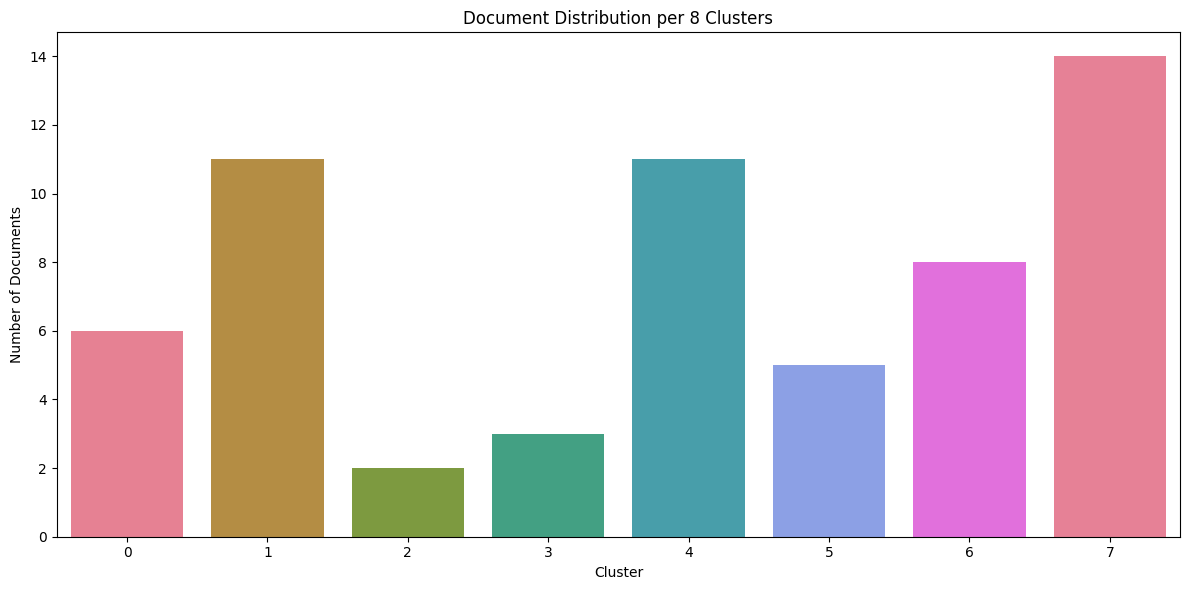


Cluster and Genre Distribution:
genre    action  comedy  drama  horror  musical  romance  sci-fi  thriller  \
cluster                                                                      
0             4       0      0       0        1        1       0         0   
1             4       3      0       1        0        1       0         1   
2             1       0      0       0        0        1       0         0   
3             3       0      0       0        0        0       0         0   
4             8       1      0       0        0        0       1         1   
5             2       1      1       1        0        0       0         0   
6             2       5      0       0        0        0       0         0   
7            12       1      1       0        0        0       0         0   

genre    unknown  
cluster           
0              0  
1              1  
2              0  
3              0  
4              0  
5              0  
6              1  
7              

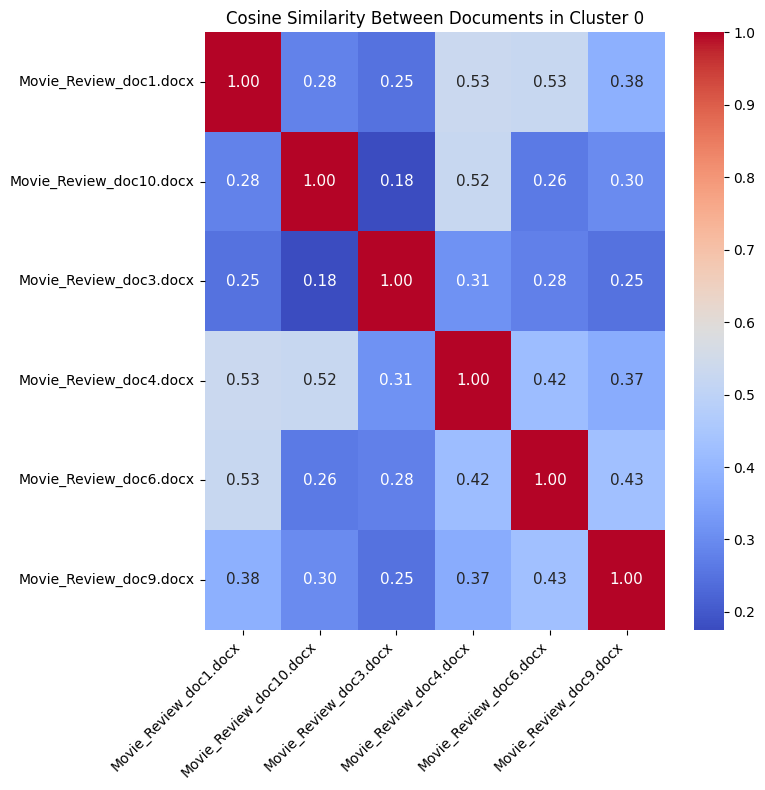

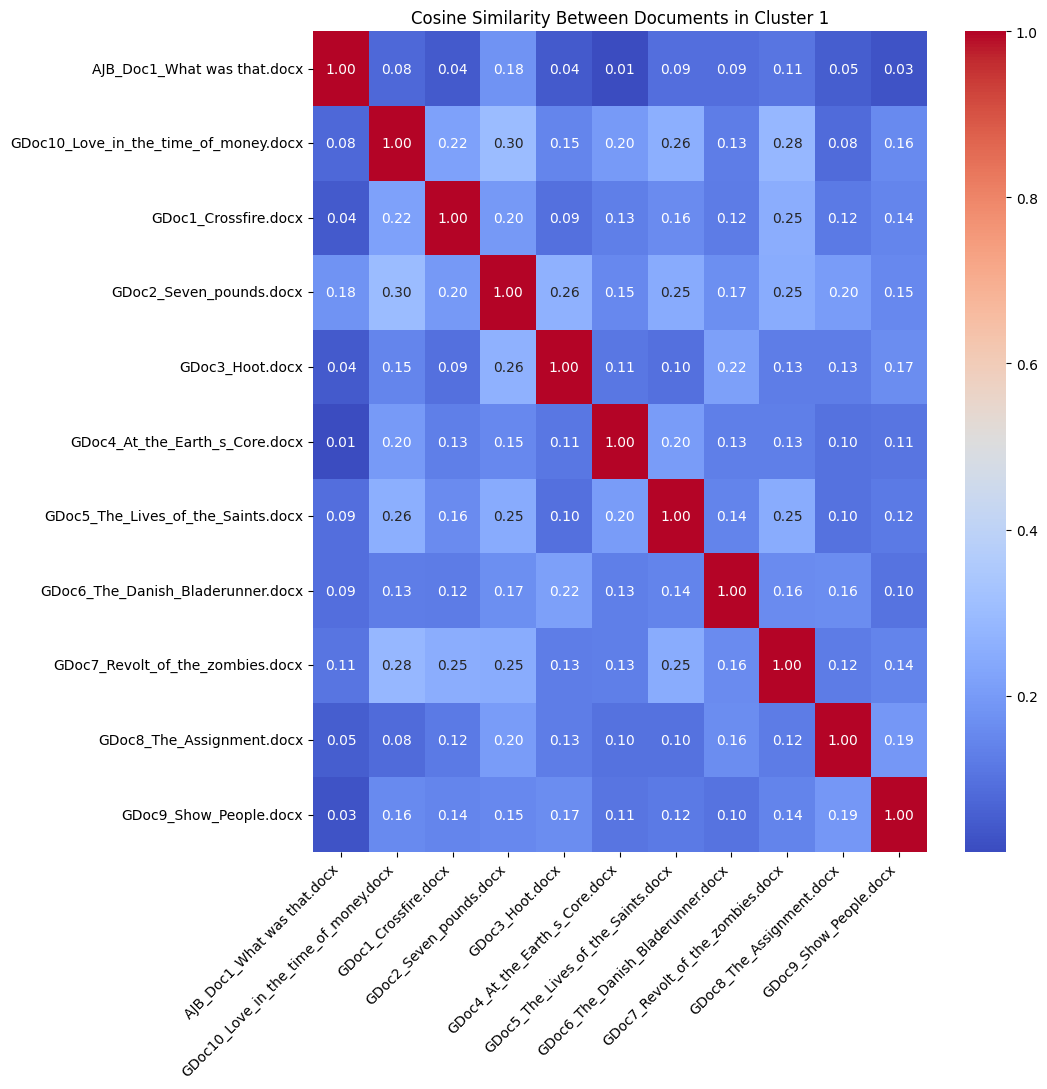

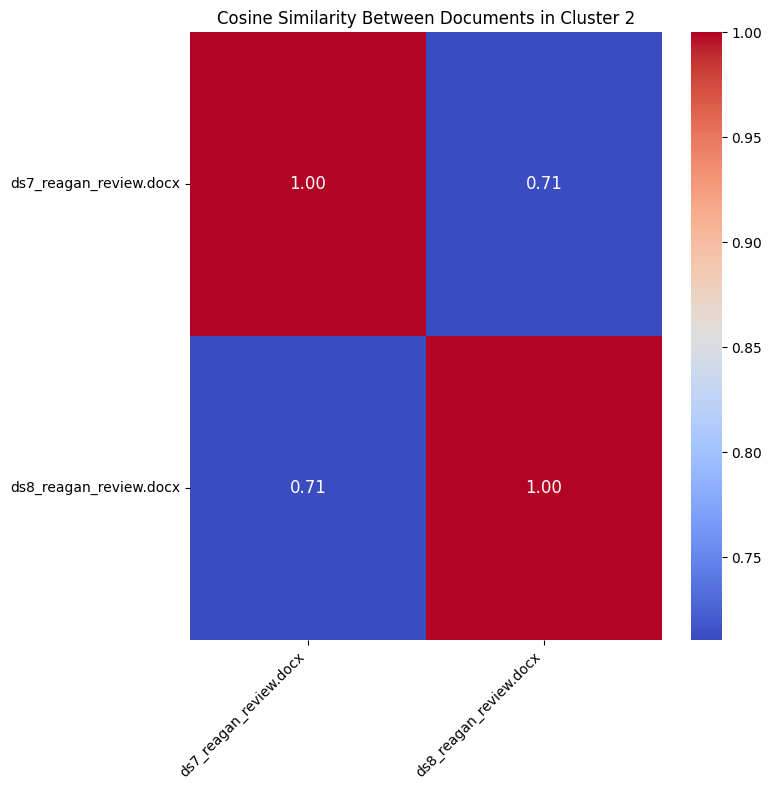

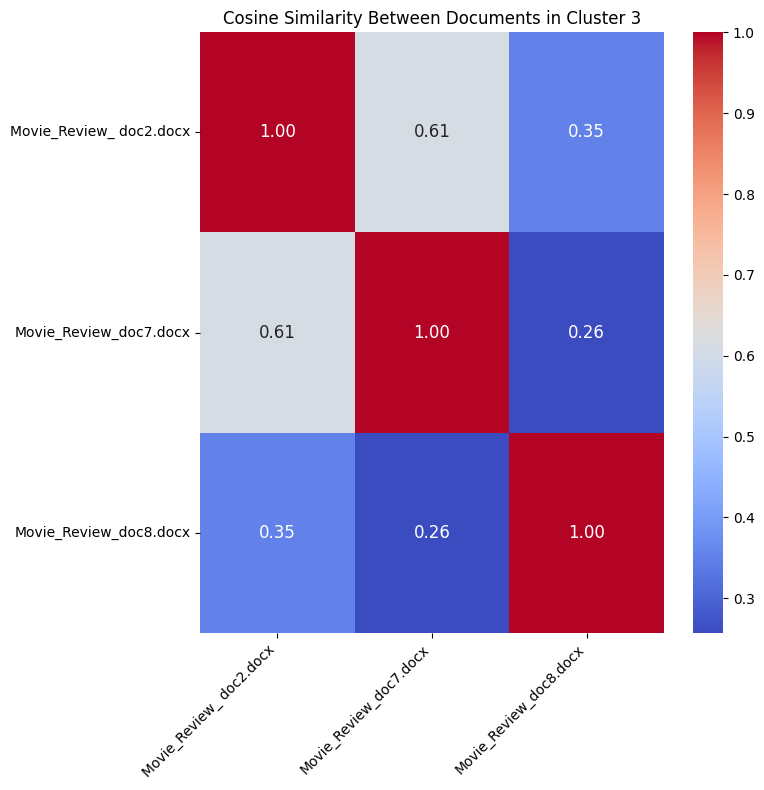

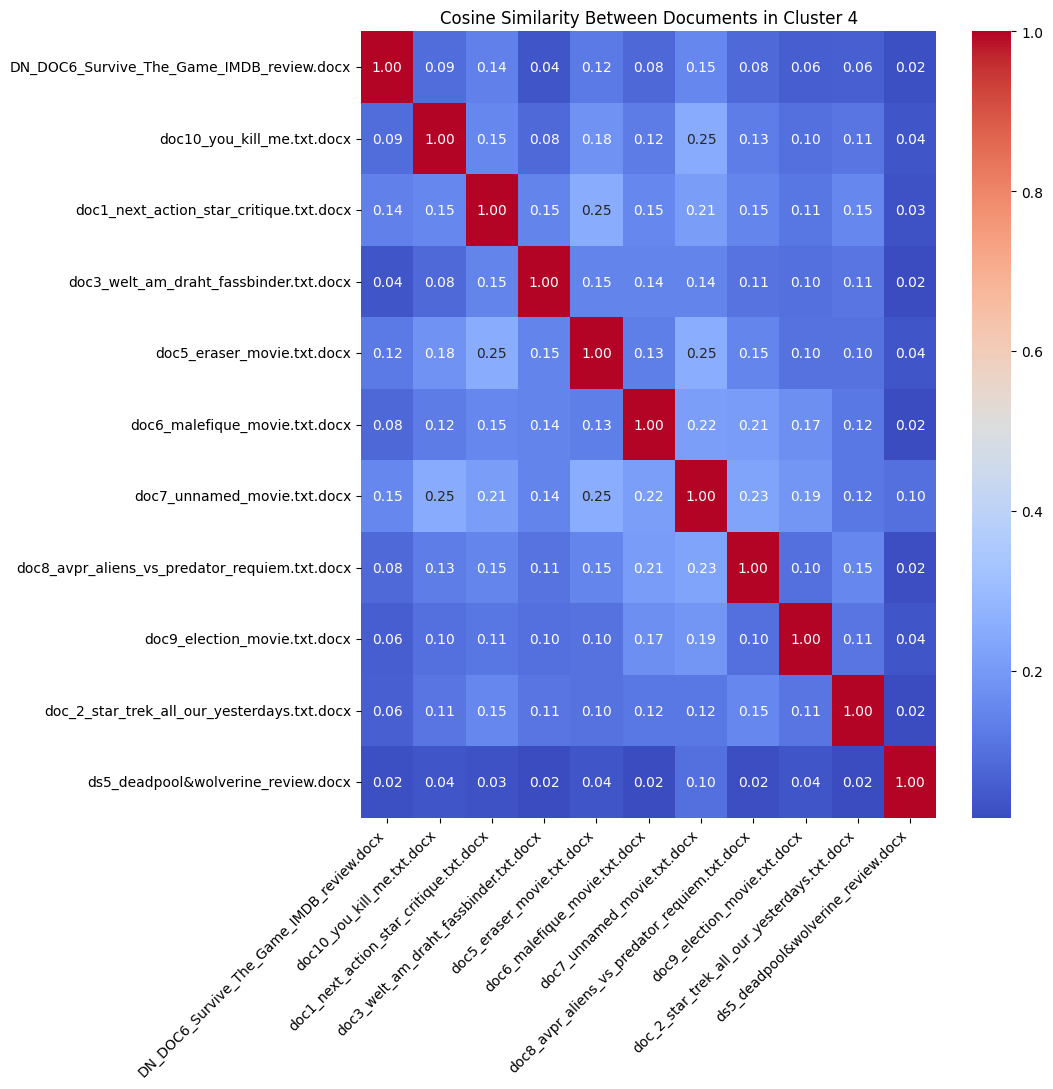

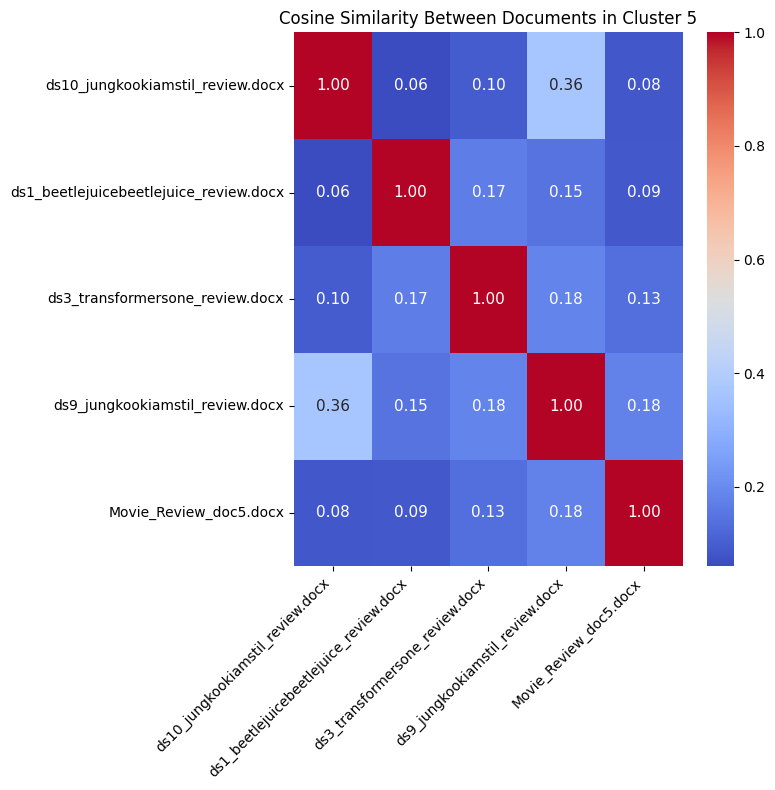

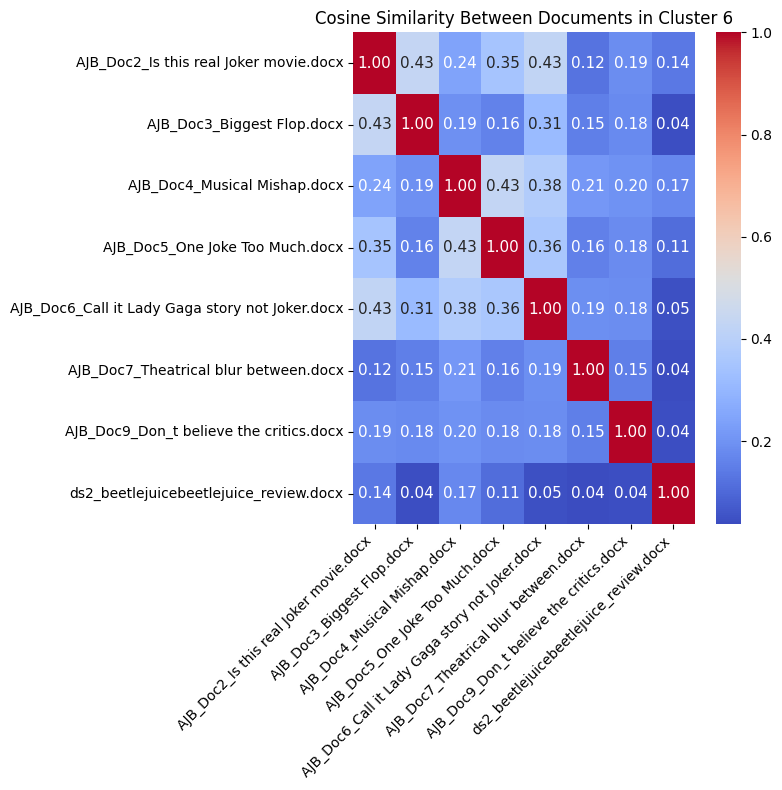

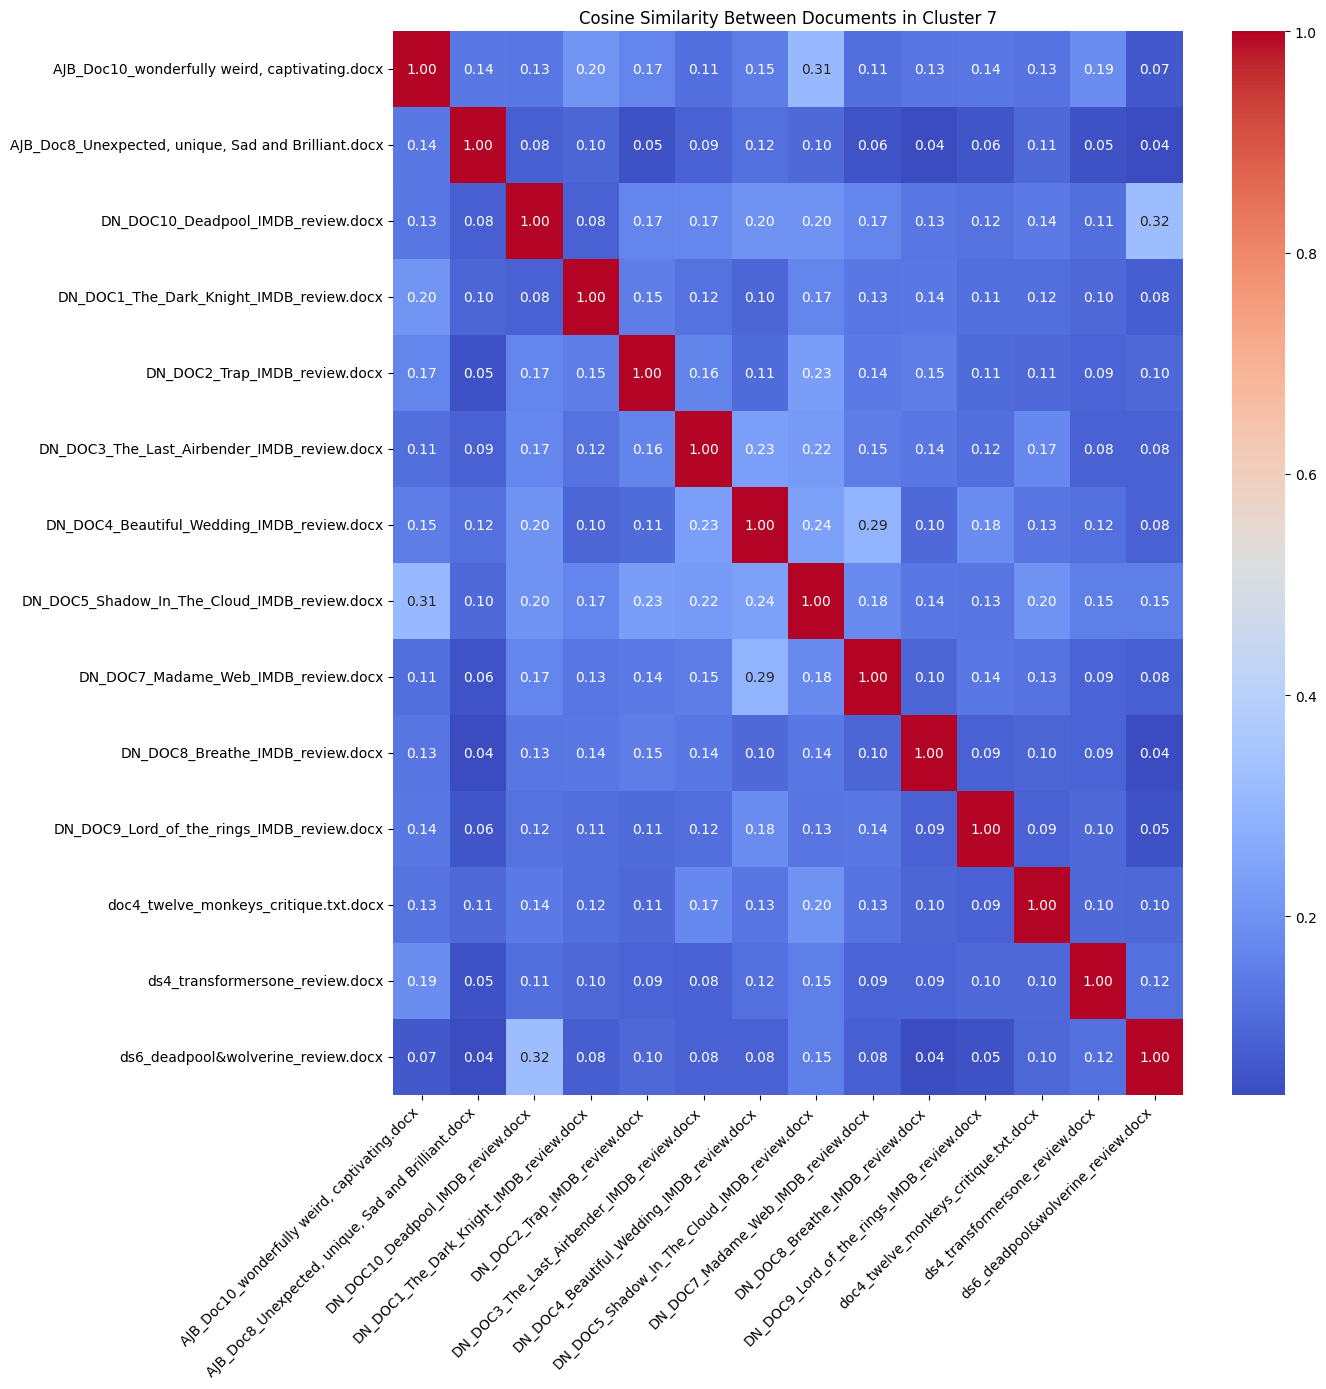

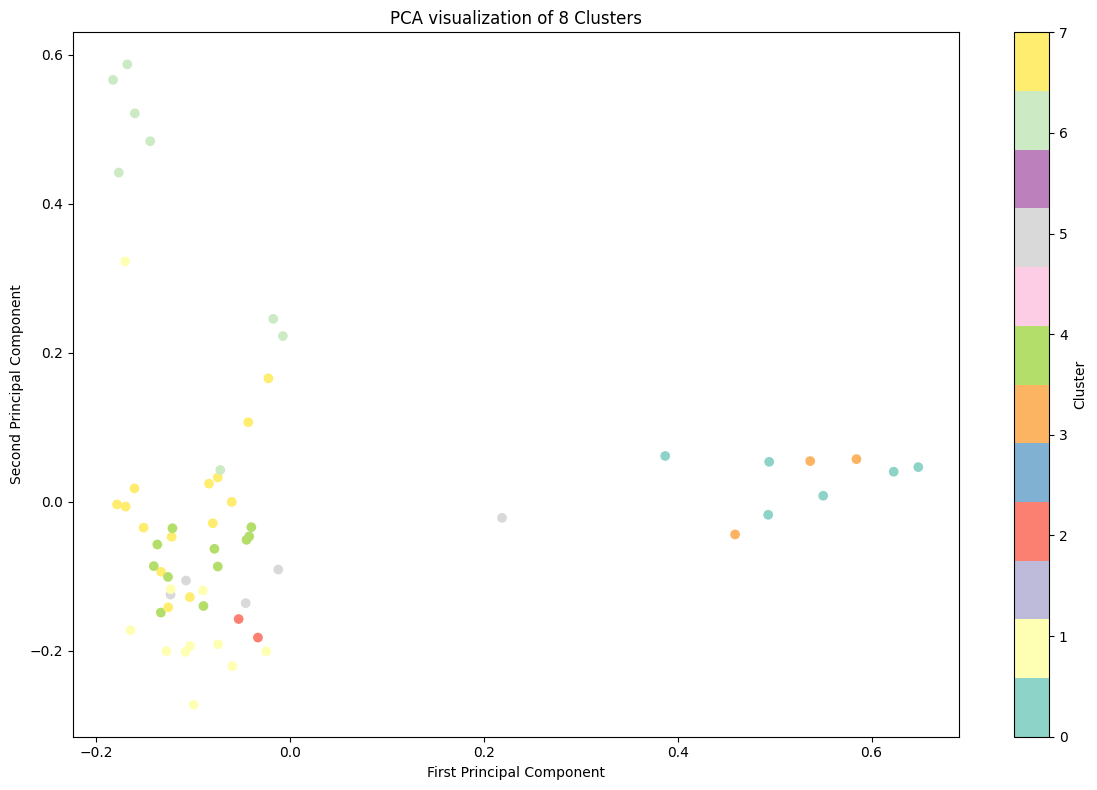

In [24]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import spacy
from docx import Document
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from fuzzywuzzy import fuzz  # Fuzzy string matching

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Step 1: Define a function to read the text from .docx files
def read_docx_file(file_path):
    doc = Document(file_path)
    full_text = []
    for paragraph in doc.paragraphs:
        full_text.append(paragraph.text)
    return "\n".join(full_text)

# Step 2: Specify the folder containing the Word documents
folder_path = r'C:\Users\Raspatel\Downloads\NLP Assignment two\Movie Review'

# Step 3: Read all .docx files from the folder
documents = []
filenames = []
for filename in os.listdir(folder_path):
    if filename.endswith(".docx"):
        file_path = os.path.join(folder_path, filename)
        text = read_docx_file(file_path)
        documents.append(text)
        filenames.append(filename)

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters, digits, etc.
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    # Remove 'br' tags explicitly
    text = text.replace('br', '')
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]  # Lemmatization
    return ' '.join(tokens)

# Preprocess all reviews
preprocessed_reviews = [preprocess_text(review) for review in documents]

# Step 4: Extract genres from the reviews using an enriched list of genres and synonyms
possible_genres = {
    'action': ['action', 'explosion', 'fight', 'combat', 'battle', 'war', 'chase'],
    'comedy': ['comedy', 'funny', 'humor', 'laugh', 'joke', 'hilarious', 'light-hearted'],
    'drama': ['drama', 'dramatic', 'emotion', 'serious', 'intense', 'melodrama'],
    'thriller': ['thriller', 'suspense', 'tense', 'nail-biting', 'edge of your seat', 'crime'],
    'romance': ['romance', 'love', 'relationship', 'affair', 'passion', 'heartwarming'],
    'horror': ['horror', 'scary', 'fear', 'fright', 'terrifying', 'ghost', 'creepy', 'blood'],
    'sci-fi': ['sci-fi', 'science fiction', 'space', 'alien', 'futuristic', 'robot', 'time travel'],
    'fantasy': ['fantasy', 'magic', 'magical', 'mythical', 'wizard', 'fairy', 'supernatural'],
    'adventure': ['adventure', 'journey', 'explore', 'expedition', 'quest', 'mission'],
    'musical': ['musical', 'song', 'dance', 'choreography', 'melody', 'performance'],
    'documentary': ['documentary', 'real life', 'non-fiction', 'true story', 'biography', 'educational']
}

def extract_genre(text, genre_dict, threshold=80):
    text_lower = text.lower()
    for genre, keywords in genre_dict.items():
        for keyword in keywords:
            if keyword in text_lower or fuzz.partial_ratio(keyword, text_lower) > threshold:
                return genre
    return 'unknown'

# Extract genres for each document
extracted_genres = [extract_genre(review, possible_genres) for review in preprocessed_reviews]

# Create TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1, 2), max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_reviews)

# Normalize the TF-IDF matrix
tfidf_matrix_normalized = normalize(tfidf_matrix, norm='l2', axis=1)

# Apply KMeans clustering with 8 clusters
optimal_clusters = 8  # Changed from 3 to 8
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(tfidf_matrix_normalized)

# Create DataFrame with document names, extracted genres, and cluster labels
movie_reviews = pd.DataFrame({
    'document': filenames,
    'genre': extracted_genres,
    'cluster': cluster_labels
})

# Visualization 1: Document distribution per cluster with updated seaborn syntax
plt.figure(figsize=(12, 6))
sns.countplot(data=movie_reviews, x='cluster', hue='cluster', palette='husl', legend=False)
plt.title('Document Distribution per 8 Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Documents')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Compare clusters with extracted genres
print("\nCluster and Genre Distribution:")
cluster_genre_dist = pd.crosstab(movie_reviews['cluster'], movie_reviews['genre'])
print(cluster_genre_dist)

# Calculate and display silhouette score
silhouette_avg = silhouette_score(tfidf_matrix_normalized.toarray(), cluster_labels)
print(f"\nSilhouette Score for 8 clusters: {silhouette_avg:.3f}")

# Cosine Similarity for all documents
cosine_sim = cosine_similarity(tfidf_matrix_normalized)

# Visualization 2: Cosine Similarity Matrices for each cluster
# Modified to handle 8 clusters with better visualization
for i in range(optimal_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    if len(cluster_indices) > 0:  # Only create visualization if cluster has documents
        selected_docs = movie_reviews.iloc[cluster_indices]
        similarity_matrix = cosine_sim[cluster_indices, :][:, cluster_indices]
        
        # Adjust figure size based on number of documents in cluster
        fig_size = min(max(8, len(cluster_indices)), 15)
        plt.figure(figsize=(fig_size, fig_size))
        
        # Create heatmap with smaller font size for larger clusters
        font_size = max(8, 12 - len(cluster_indices) // 5)  # Adjust font size based on cluster size
        sns.heatmap(similarity_matrix, 
                   annot=True, 
                   cmap='coolwarm', 
                   xticklabels=selected_docs['document'],
                   yticklabels=selected_docs['document'],
                   fmt='.2f',  # Show only 2 decimal places
                   annot_kws={'size': font_size})
        
        plt.title(f'Cosine Similarity Between Documents in Cluster {i}')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

# Additional visualization: PCA to visualize clusters in 2D
pca = PCA(n_components=2)
tfidf_pca = pca.fit_transform(tfidf_matrix_normalized.toarray())

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=cluster_labels, cmap='Set3')
plt.title('PCA visualization of 8 Clusters')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()


### Fixed Code for Genre


Genre Analysis Summary:
--------------------------------------------------
action: 36 documents (60.0%)
comedy: 15 documents (25.0%)
thriller: 3 documents (5.0%)
drama: 2 documents (3.3%)
horror: 2 documents (3.3%)
sci-fi: 1 documents (1.7%)
musical: 1 documents (1.7%)


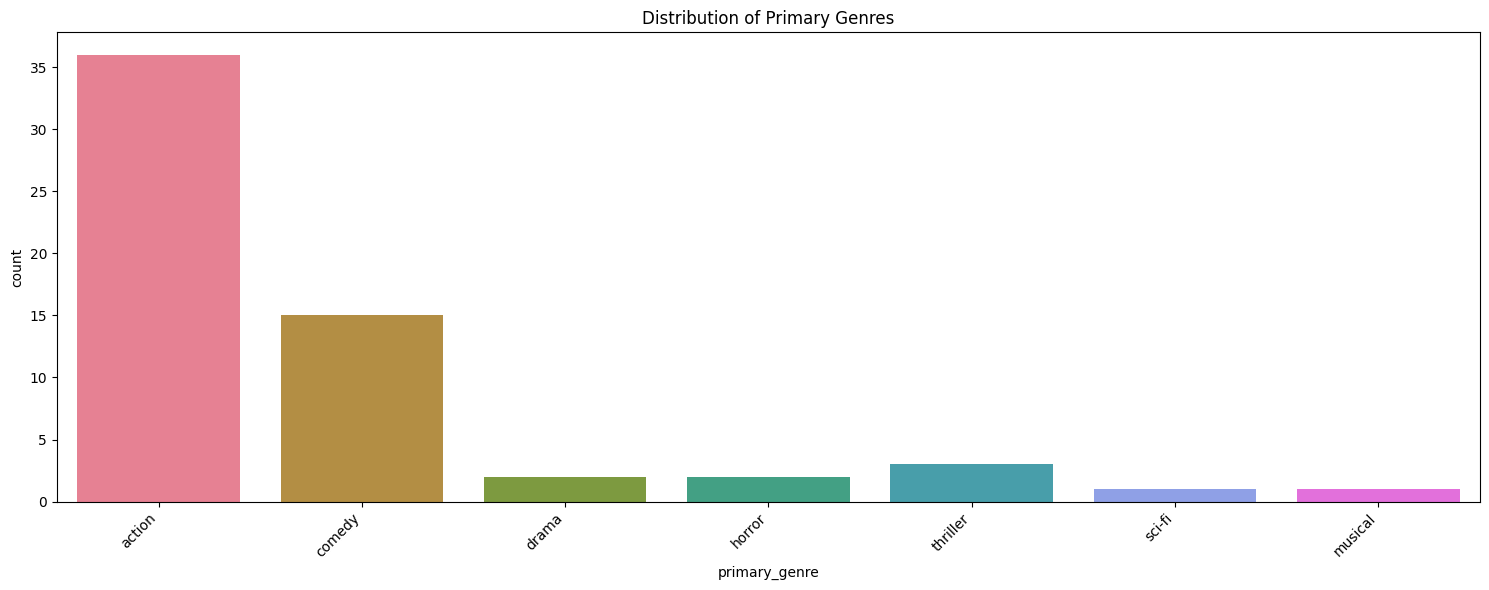

In [26]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import spacy
from docx import Document
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from fuzzywuzzy import fuzz
from collections import Counter

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def read_docx_file(file_path):
    doc = Document(file_path)
    full_text = []
    for paragraph in doc.paragraphs:
        full_text.append(paragraph.text)
    return "\n".join(full_text)

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove 'br' tags explicitly
    text = text.replace('br', '')
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# Expanded genre dictionary with comprehensive keywords
possible_genres = {
    'action': [
        'action', 'explosion', 'fight', 'combat', 'battle', 'war', 'chase', 'stunts', 
        'martial arts', 'violent', 'action-packed', 'blockbuster', 'superhero', 
        'gunfight', 'showdown', 'revenge', 'intense action', 'warrior', 'battlefield',
        'military', 'racing', 'adrenaline'
    ],
    'comedy': [
        'comedy', 'funny', 'humor', 'laugh', 'joke', 'hilarious', 'light-hearted', 
        'comedic', 'gag', 'parody', 'slapstick', 'witty', 'satire', 'romantic comedy',
        'sitcom', 'spoof', 'quirky', 'humorous', 'comedy drama', 'stand-up',
        'entertaining', 'amusing', 'fun', 'silly'
    ],
    'drama': [
        'drama', 'dramatic', 'emotion', 'serious', 'intense', 'melodrama', 'psychological',
        'character-driven', 'emotional', 'powerful', 'thought-provoking', 'compelling',
        'moving', 'profound', 'realistic', 'slice of life', 'poignant', 'tragic',
        'family drama', 'social issues', 'character study', 'relationship drama'
    ],
    'thriller': [
        'thriller', 'suspense', 'tense', 'nail-biting', 'edge of your seat', 'crime',
        'mystery', 'detective', 'psychological thriller', 'conspiracy', 'twist',
        'gripping', 'intriguing', 'criminal', 'murder', 'investigation', 'suspenseful',
        'noir', 'police', 'detective story', 'whodunit'
    ],
    'romance': [
        'romance', 'love', 'relationship', 'affair', 'passion', 'heartwarming', 'romantic',
        'dating', 'love story', 'romantic drama', 'heart-touching', 'soulmate',
        'couple', 'wedding', 'chemistry', 'emotional connection', 'breakup',
        'romantic relationship', 'courtship', 'love interest'
    ],
    'horror': [
        'horror', 'scary', 'fear', 'fright', 'terrifying', 'ghost', 'creepy', 'blood',
        'supernatural horror', 'monster', 'zombie', 'slasher', 'gore', 'frightening',
        'spooky', 'haunted', 'disturbing', 'eerie', 'paranormal', 'psychological horror',
        'terror', 'demon', 'creature'
    ],
    'sci-fi': [
        'sci-fi', 'science fiction', 'space', 'alien', 'futuristic', 'robot', 'time travel',
        'dystopian', 'cyberpunk', 'artificial intelligence', 'future', 'technology',
        'spaceship', 'extraterrestrial', 'scientific', 'advanced technology', 'cyborg',
        'post-apocalyptic', 'virtual reality', 'genetic', 'quantum'
    ],
    'fantasy': [
        'fantasy', 'magic', 'magical', 'mythical', 'wizard', 'fairy', 'supernatural',
        'dragon', 'mythological', 'enchanted', 'sorcery', 'witch', 'mystical',
        'folklore', 'epic fantasy', 'magical creatures', 'fairy tale', 'legend',
        'spells', 'medieval fantasy', 'sword and sorcery'
    ],
    'adventure': [
        'adventure', 'journey', 'explore', 'expedition', 'quest', 'mission', 'discovery',
        'treasure', 'travel', 'wanderlust', 'exploration', 'survival', 'wilderness',
        'epic adventure', 'exciting journey', 'expedition', 'dangerous mission',
        'adventurous', 'voyage', 'discovery'
    ],
    'musical': [
        'musical', 'song', 'dance', 'choreography', 'melody', 'performance', 'singing',
        'broadway', 'concert', 'music', 'rhythm', 'theatrical', 'stage performance',
        'opera', 'musical number', 'soundtrack', 'orchestral', 'performer', 'dancer',
        'choreographed'
    ],
    'documentary': [
        'documentary', 'real life', 'non-fiction', 'true story', 'biography', 'educational',
        'historical', 'factual', 'informative', 'real events', 'documentary film',
        'actual events', 'reality', 'interview', 'archive footage', 'historical events',
        'investigative', 'journalism', 'social documentary'
    ],
    'animation': [
        'animation', 'animated', 'cartoon', 'pixar', 'disney', 'anime', 'animated film',
        'animated feature', 'cgi', 'computer animation', '3d animation', 'animated series',
        'stop motion', 'claymation', 'animated movie', 'family animation'
    ],
    'crime': [
        'crime', 'criminal', 'heist', 'gangster', 'mafia', 'police', 'detective',
        'investigation', 'law enforcement', 'organized crime', 'crime drama',
        'crime thriller', 'murder mystery', 'corruption', 'criminal underworld'
    ],
    'biographical': [
        'biographical', 'biography', 'true story', 'real life', 'historical figure',
        'life story', 'based on real events', 'historical biography', 'memoir',
        'real person', 'historical drama', 'life history', 'personal story'
    ],
    'sports': [
        'sports', 'athlete', 'competition', 'game', 'tournament', 'championship',
        'boxing', 'football', 'baseball', 'basketball', 'soccer', 'olympic',
        'sporting', 'coach', 'team', 'victory', 'underdog', 'sports drama'
    ],
    'western': [
        'western', 'cowboy', 'wild west', 'frontier', 'ranch', 'sheriff', 'gunslinger',
        'outlaw', 'western frontier', 'old west', 'western drama', 'western adventure',
        'prairie', 'saloon', 'horseback', 'desert'
    ]
}

def analyze_unknown_terms(text, existing_genres):
    """
    Analyze text for potential new genre terms by looking at frequent terms
    that don't match existing genres
    """
    # Tokenize and get frequent terms
    doc = nlp(text.lower())
    words = [token.text for token in doc if token.is_alpha and not token.is_stop]
    word_freq = Counter(words)
    
    # Get all existing genre keywords
    existing_keywords = set()
    for keywords in existing_genres.values():
        existing_keywords.update(set(keywords))
    
    # Find frequent terms that aren't in existing keywords
    new_terms = []
    for word, freq in word_freq.most_common(20):
        if word not in existing_keywords and freq > 1:
            new_terms.append(word)
    
    return new_terms

def extract_genres(text, genre_dict, threshold=75):
    """
    Extract multiple potential genres from text using enhanced matching
    Returns a list of tuples (genre, confidence_score)
    """
    text_lower = text.lower()
    genre_matches = []
    
    # First pass: Direct keyword matching
    for genre, keywords in genre_dict.items():
        max_score = 0
        matching_keywords = []
        
        for keyword in keywords:
            # Calculate both direct matching and fuzzy matching scores
            direct_match = 1.0 if keyword in text_lower else 0.0
            fuzzy_score = fuzz.partial_ratio(keyword, text_lower) / 100
            
            # Take the maximum score between direct and fuzzy matching
            score = max(direct_match, fuzzy_score)
            if score > max_score:
                max_score = score
                
            if score > threshold/100:
                matching_keywords.append(keyword)
        
        # Calculate confidence based on number of matching keywords and their scores
        if matching_keywords:
            confidence = min(1.0, max_score * (1 + 0.1 * len(matching_keywords)))
            genre_matches.append((genre, confidence))
    
    # Sort by confidence score
    genre_matches.sort(key=lambda x: x[1], reverse=True)
    
    if not genre_matches:
        # Analyze unknown text for potential new terms
        new_terms = analyze_unknown_terms(text, genre_dict)
        return [('unknown', 0.0, new_terms)]
    
    return genre_matches

def get_primary_genre(text, genre_dict, threshold=75):
    """
    Get the primary genre with the highest confidence score
    """
    genres = extract_genres(text, genre_dict, threshold)
    return genres[0][0]

# Main execution
if __name__ == "__main__":
    # Specify the folder containing the Word documents
    folder_path = r'C:\Users\Raspatel\Downloads\NLP Assignment two\Movie Review'

    # Read and process documents
    documents = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".docx"):
            file_path = os.path.join(folder_path, filename)
            text = read_docx_file(file_path)
            documents.append(text)
            filenames.append(filename)

    # Preprocess reviews
    preprocessed_reviews = [preprocess_text(review) for review in documents]

    # Extract genres and analyze unknown terms
    genre_results = [extract_genres(review, possible_genres) for review in preprocessed_reviews]
    primary_genres = [result[0][0] for result in genre_results]
    
    # Collect terms from unknown genres
    unknown_terms = []
    for doc, genres in zip(preprocessed_reviews, genre_results):
        if genres[0][0] == 'unknown':
            unknown_terms.extend(genres[0][2])  # Collect new terms
    
    if unknown_terms:
        print("\nFrequent terms in unknown genres:")
        print(Counter(unknown_terms).most_common(20))

    # Create TF-IDF matrix and clustering
    tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1, 2), max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_reviews)
    tfidf_matrix_normalized = normalize(tfidf_matrix, norm='l2', axis=1)

    # Clustering
    optimal_clusters = 8
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(tfidf_matrix_normalized)

    # Create DataFrame with enhanced information
    movie_reviews = pd.DataFrame({
        'document': filenames,
        'primary_genre': primary_genres,
        'all_genres': [', '.join([g[0] for g in result if g[0] != 'unknown']) 
                      for result in genre_results],
        'genre_confidence': [result[0][1] for result in genre_results],
        'cluster': cluster_labels
    })

    # Print analysis summary
    print("\nGenre Analysis Summary:")
    print("-" * 50)
    genre_counts = Counter(primary_genres)
    total_docs = len(primary_genres)
    
    for genre, count in genre_counts.most_common():
        percentage = (count / total_docs) * 100
        print(f"{genre}: {count} documents ({percentage:.1f}%)")

    # Visualization of genre distribution
    plt.figure(figsize=(15, 6))
    sns.countplot(
        data=movie_reviews, 
        x='primary_genre',
        hue='primary_genre',  # Add hue parameter
        legend=False,         # Hide legend since it's redundant
        palette='husl'
    )
    plt.title('Distribution of Primary Genres')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Generate word cloud for unknown documents
    if 'unknown' in genre_counts:
        unknown_texts = ' '.join([doc for doc, genre in zip(preprocessed_reviews, primary_genres) 
                                if genre == 'unknown'])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(unknown_texts)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Unknown Genre Documents')
        plt.show()

    # Print detailed analysis of unknown documents
    unknown_reviews = movie_reviews[movie_reviews['primary_genre'] == 'unknown']
    if not unknown_reviews.empty:
        print("\nDetailed Analysis of Unknown Genre Documents:")
        print("-" * 50)
        for idx, row in unknown_reviews.iterrows():
            print(f"Document: {row['document']}")
            print(f"Cluster: {row['cluster']}")
            # Get the original text and analyze frequent terms
            doc_text = documents[filenames.index(row['document'])]
            new_terms = analyze_unknown_terms(doc_text, possible_genres)
            print("Frequent terms:", ', '.join(new_terms[:10]))
            print("-" * 30)

### Bar Graph Showing Sentiment Analysis
Insight- Bar graph (also known as a bar chart) is a type of graph that visually represents categorical data using rectangular bars. Each bar's height (or length, in the case of horizontal bar graphs) corresponds to the value or frequency of the category it represents. The bars can be arranged either vertically or horizontally.
For Visualization used it for Average Sentiment by Genre, Average Sentiment by Cluster, Number of Reviews by Genre and Number of Reviews by Cluster
Insight-The bar graph for Average Sentiment by Genre would show how each genre (e.g., Action, Comedy, Drama) is perceived based on sentiment analysis. 
Romantic genres may have a higher average positive sentiment.
Horror or Thriller genres could lean towards a more negative sentiment.
Drama might exhibit a wider sentiment range, indicating both positive and negative emotions depending on the movie's tone.
Insight: The bar graph for Average Sentiment by Cluster provides insights into how different clusters (thematic groups) are perceived emotionally. 
A cluster focusing on uplifting, inspirational movies may show a predominantly positive sentiment.
A cluster related to dark psychological movies could display negative sentiment.
Mixed clusters may exhibit a balanced sentiment, indicating a range of emotional responses
Insight: The bar graph for Number of Reviews by Genre would show the distribution of reviews across different genres. 
Action and Drama have more reviews, indicating popularity.
Romance or Comedy could have fewer reviews if the dataset is skewed towards more dramatic or action-oriented films.
Insight: The bar graph for Number of Reviews by Cluster would reveal how many reviews fall into each cluster. 
Some clusters might have significantly more reviews, indicating common themes among multiple movies. Smaller clusters could represent niche themes or less common topics.


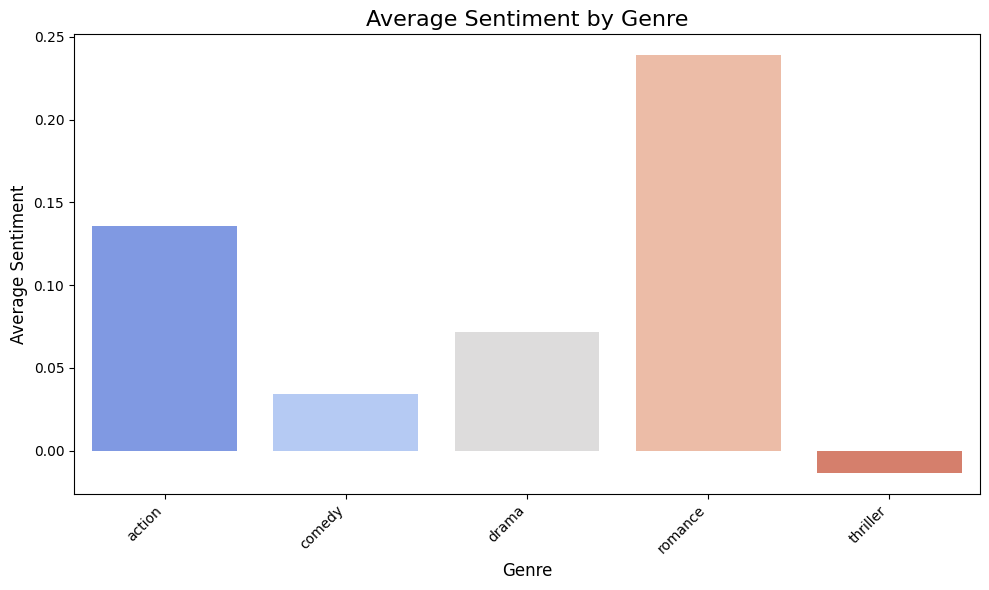

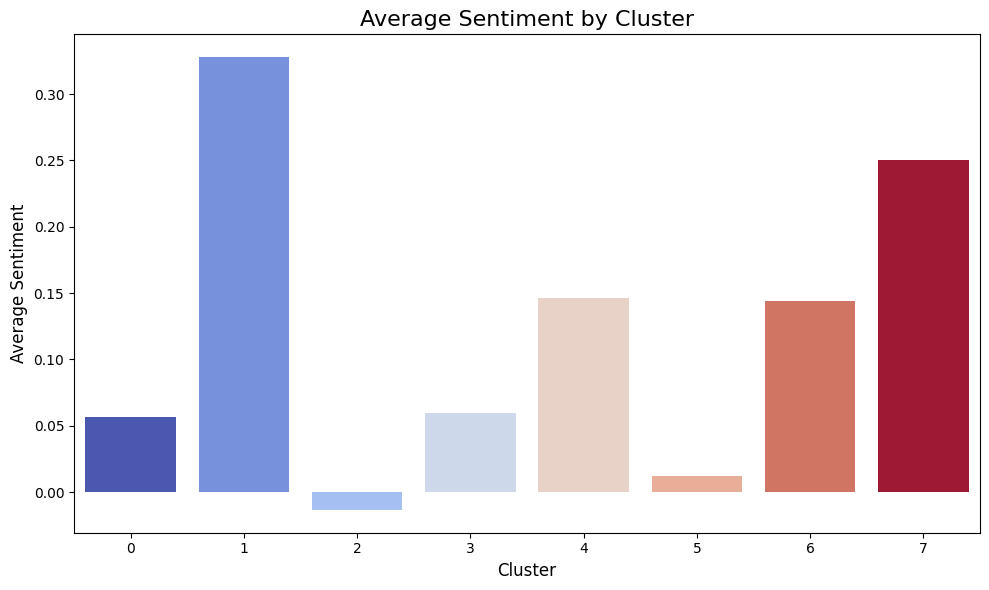

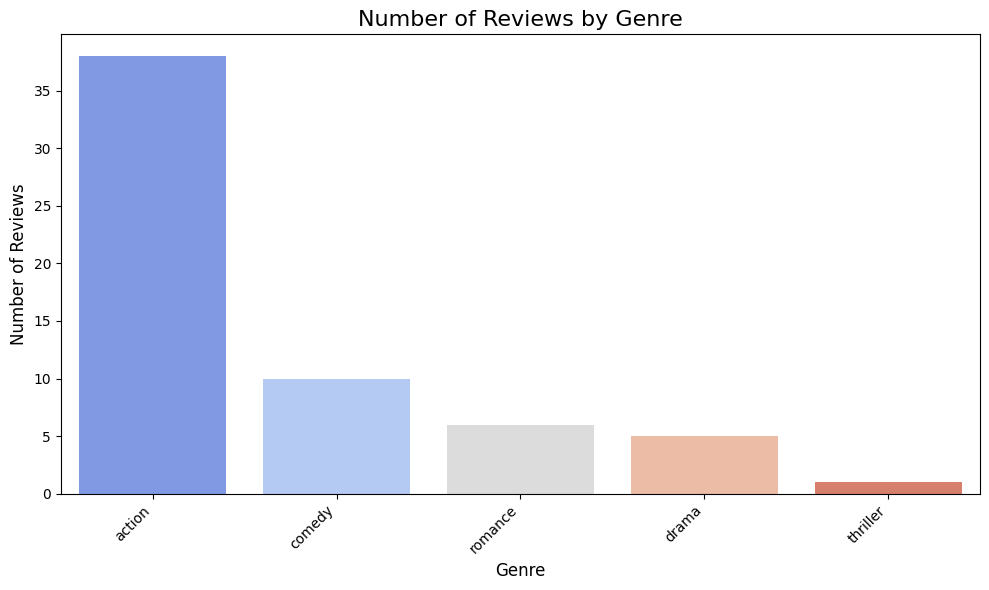

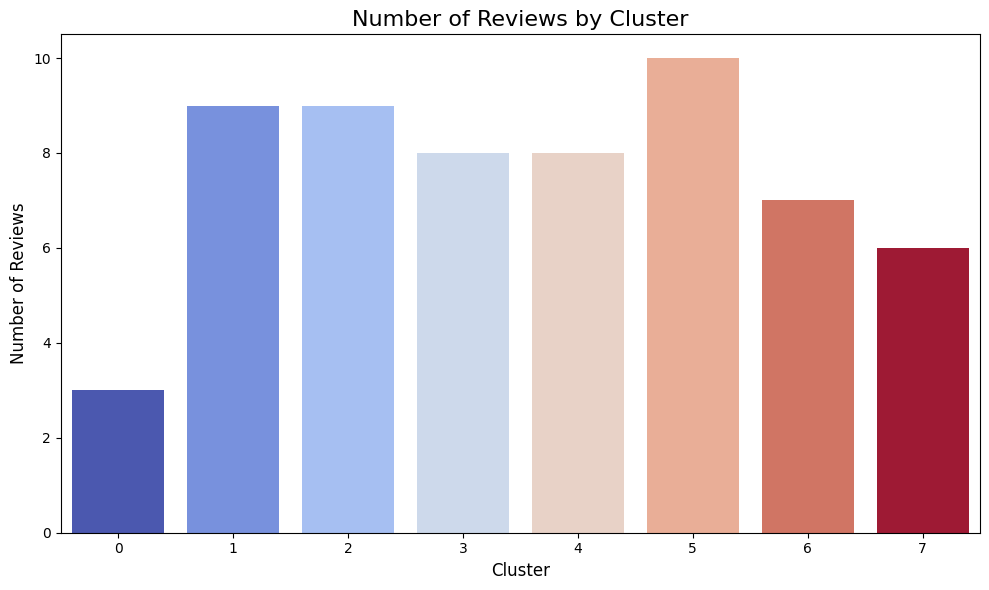

In [28]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from docx import Document
import pandas as pd
from fuzzywuzzy import fuzz  # Fuzzy string matching
from textblob import TextBlob  # Sentiment analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Step 1: Define a function to read the text from .docx files
def read_docx_file(file_path):
    doc = Document(file_path)
    full_text = []
    for paragraph in doc.paragraphs:
        full_text.append(paragraph.text)
    return "\n".join(full_text)

# Step 2: Specify the folder containing the Word documents
folder_path = r'C:\Users\Raspatel\Downloads\NLP Assignment two\Movie Review'

# Step 3: Read all .docx files from the folder
documents = []
filenames = []
for filename in os.listdir(folder_path):
    if filename.endswith(".docx"):
        file_path = os.path.join(folder_path, filename)
        text = read_docx_file(file_path)
        documents.append(text)
        filenames.append(filename)

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters, digits, etc.
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    # Remove 'br' tags explicitly
    text = text.replace('br', '')
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]  # Lemmatization
    return ' '.join(tokens)

# Preprocess all reviews
preprocessed_reviews = [preprocess_text(review) for review in documents]

# Sentiment analysis using TextBlob
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Returns sentiment polarity (-1 to 1)

# Apply sentiment analysis to each review
sentiments = [analyze_sentiment(review) for review in preprocessed_reviews]

# Step 4: Extract genres from the reviews using an enriched list of genres and synonyms
possible_genres = {
    'action': ['action', 'explosion', 'fight', 'combat', 'battle', 'war', 'chase'],
    'comedy': ['comedy', 'funny', 'humor', 'laugh', 'joke', 'hilarious', 'light-hearted'],
    'drama': ['drama', 'dramatic', 'emotion', 'serious', 'intense', 'melodrama'],
    'thriller': ['thriller', 'suspense', 'tense', 'nail-biting', 'edge of your seat', 'crime'],
    'romance': ['romance', 'love', 'relationship', 'affair', 'passion', 'heartwarming'],
    'horror': ['horror', 'scary', 'fear', 'fright', 'terrifying', 'ghost', 'creepy', 'blood'],
    'sci-fi': ['sci-fi', 'science fiction', 'space', 'alien', 'futuristic', 'robot', 'time travel'],
    'fantasy': ['fantasy', 'magic', 'magical', 'mythical', 'wizard', 'fairy', 'supernatural'],
    'adventure': ['adventure', 'journey', 'explore', 'expedition', 'quest', 'mission'],
    'musical': ['musical', 'song', 'dance', 'choreography', 'melody', 'performance'],
    'documentary': ['documentary', 'real life', 'non-fiction', 'true story', 'biography', 'educational']
}

# Function to extract genre based on keyword matching with synonyms (including fuzzy matching)
def extract_genre(text, genre_dict, threshold=70):
    text_lower = text.lower()  # Convert text to lowercase for case-insensitive matching
    for genre, keywords in genre_dict.items():
        for keyword in keywords:
            if keyword in text_lower or fuzz.partial_ratio(keyword, text_lower) > threshold:
                return genre  # Return the genre as soon as a match is found
    return 'unknown'  # Return 'unknown' if no genre is found

# Extract genres for each document using the improved extraction function
extracted_genres = [extract_genre(review, possible_genres) for review in preprocessed_reviews]

# Create TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1, 2), max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_reviews)

# Normalize the TF-IDF matrix
tfidf_matrix_normalized = normalize(tfidf_matrix)

# Step 5: Apply KMeans clustering with 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans_labels = kmeans.fit_predict(tfidf_matrix_normalized)

# Step 6: Create DataFrame with document names, extracted genres, sentiment scores, and cluster labels
movie_reviews = pd.DataFrame({
    'document': filenames,
    'genre': extracted_genres,
    'sentiment': sentiments,
    'cluster': kmeans_labels
})

# Step 7: Group sentiment by genre and cluster to prepare for bar chart
genre_sentiment = movie_reviews.groupby('genre')['sentiment'].mean()
cluster_sentiment = movie_reviews.groupby('cluster')['sentiment'].mean()

# Calculate the number of reviews per genre and cluster
genre_review_count = movie_reviews['genre'].value_counts()
cluster_review_count = movie_reviews['cluster'].value_counts()

# Bar Chart for Sentiment by Genre
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_sentiment.index, y=genre_sentiment.values, hue=genre_sentiment.index, palette="coolwarm", dodge=False, legend=False)
plt.title('Average Sentiment by Genre', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Bar Chart for Sentiment by Cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_sentiment.index, y=cluster_sentiment.values, hue=cluster_sentiment.index, palette="coolwarm", dodge=False, legend=False)
plt.title('Average Sentiment by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)
plt.tight_layout()
plt.show()

# Bar Chart for Number of Reviews by Genre
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_review_count.index, y=genre_review_count.values, hue=genre_review_count.index, palette="coolwarm", dodge=False, legend=False)
plt.title('Number of Reviews by Genre', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Bar Chart for Number of Reviews by Cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_review_count.index, y=cluster_review_count.values, hue=cluster_review_count.index, palette="coolwarm", dodge=False, legend=False)
plt.title('Number of Reviews by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.tight_layout()
plt.show()


### Top Terms for Reviews

In [30]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import spacy
from docx import Document
import pandas as pd
from textblob import TextBlob

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Step 1: Define a function to read the text from .docx files
def read_docx_file(file_path):
    doc = Document(file_path)
    full_text = []
    for paragraph in doc.paragraphs:
        full_text.append(paragraph.text)
    return "\n".join(full_text)

# Step 2: Specify the folder containing the Word documents
folder_path = r'C:\Users\Raspatel\Downloads\NLP Assignment two\Movie Review'

# Step 3: Read all .docx files from the folder
documents = []
filenames = []
for filename in os.listdir(folder_path):
    if filename.endswith(".docx"):
        file_path = os.path.join(folder_path, filename)
        text = read_docx_file(file_path)
        documents.append(text)
        filenames.append(filename)

# Preprocessing function
def preprocess_text(text):
    # Remove special characters, digits, and URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'http\S+|www\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    # Process with spaCy
    doc = nlp(text)
    # Lemmatize and remove stop words
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# Preprocess all reviews
preprocessed_reviews = [preprocess_text(review) for review in documents]

# Step 4: Function to calculate sentiment score using TextBlob
def get_sentiment_score(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Calculate sentiment scores for each preprocessed review
sentiment_scores = [get_sentiment_score(review) for review in preprocessed_reviews]

# Create a DataFrame to store sentiment scores along with filenames
sentiment_df = pd.DataFrame({
    'document': filenames,
    'review_text': preprocessed_reviews,
    'sentiment_score': sentiment_scores
})

# Classify reviews based on sentiment scores
sentiment_df['sentiment'] = sentiment_df['sentiment_score'].apply(lambda x: 'positive' if x > 0.1 else 'negative' if x < -0.1 else 'neutral')

# Step 5: Split reviews into positive and negative
positive_reviews = sentiment_df[sentiment_df['sentiment'] == 'positive']['review_text']
negative_reviews = sentiment_df[sentiment_df['sentiment'] == 'negative']['review_text']

# Step 6: Perform TF-IDF on positive reviews
pos_tf_idf = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english', max_features=10)
positive_review = pos_tf_idf.fit_transform(positive_reviews).toarray()
pos_vect_df = pd.DataFrame(positive_review, columns=pos_tf_idf.get_feature_names_out())
print("Top words for positive reviews:")
print(pos_vect_df)

# Step 7: Perform TF-IDF on negative reviews
neg_tf_idf = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english', max_features=10)
negative_review = neg_tf_idf.fit_transform(negative_reviews).toarray()
neg_vect_df = pd.DataFrame(negative_review, columns=neg_tf_idf.get_feature_names_out())
print("Top words for negative reviews:")
print(neg_vect_df)

# Step 8: General TF-IDF for clustering purposes
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1, 2), max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_reviews)

# Normalize the TF-IDF matrix
tfidf_matrix_normalized = normalize(tfidf_matrix, norm='l2', axis=1)

# Step 9: Perform K-means clustering with optimal clusters
optimal_clusters = 5  # Based on previous analysis
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(tfidf_matrix_normalized)

# Step 10: Create a DataFrame with document names and cluster labels
movie_reviews = pd.DataFrame({
    'document': filenames,
    'cluster': cluster_labels
})


Top words for positive reviews:
    beautiful  character      film      good  keywords      like      mind  \
0    0.137821   0.058902  0.895933  0.000000  0.039434  0.235609  0.000000   
1    0.000000   0.000000  0.491565  0.000000  0.216359  0.000000  0.335493   
2    0.000000   0.641599  0.108434  0.074006  0.047727  0.142578  0.000000   
3    0.000000   0.000000  0.457243  0.624137  0.201253  0.300610  0.312068   
4    0.000000   0.123792  0.282440  0.385530  0.082876  0.618958  0.000000   
5    0.000000   0.693244  0.527230  0.179917  0.116029  0.346622  0.000000   
6    0.000000   0.212935  0.323885  0.000000  0.142556  0.212935  0.000000   
7    0.000000   0.000000  0.061240  0.083592  0.053909  0.161046  0.083592   
8    0.000000   0.000000  0.785682  0.000000  0.345813  0.000000  0.000000   
9    0.000000   0.000000  0.000000  0.779735  0.167617  0.250368  0.000000   
10   0.000000   0.000000  0.000000  0.000000  0.226237  0.337928  0.350809   
11   0.000000   0.186198  0.0000

### Sentiment Analysis for Movie Reviews
Neutral Reviews: Reviews with sentiment values near 0 (e.g., 0.006635 or -0.001644) are likely neutral.
Positive Reviews: Scores closer to 1 (e.g., 0.512195, 0.401806) reflect more positive language, which genuinely praises the movie.
Negative Reviews: Scores closer to -1 (e.g., -0.244866, -0.242560) reflect more negative language, which indicate dissatisfaction or criticism.

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Raspatel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Raspatel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Reading documents...
Processing 60 documents...

Sentiment Analysis Results:
                                             document  sentiment_score  \
0       AJB_Doc10_wonderfully weird, captivating.docx         0.160372   
1                         AJB_Doc1_What was that.docx        -0.175404   
2              AJB_Doc2_Is this real Joker movie.docx         0.022222   
3                          AJB_Doc3_Biggest Flop.docx        -0.122368   
4                        AJB_Doc4_Musical Mishap.docx         0.007006   
5                     AJB_Doc5_One Joke Too Much.docx         0.069345   
6     AJB_Doc6_Call it Lady Gaga story not Joker.docx         0.128291   
7               AJB_Doc7_Theatrical blur between.docx         0.045714   
8   AJB_Doc8_Unexpected, unique, Sad and Brilliant...         0.160556   
9             AJB_Doc9_Don_t believe the critics.docx         0.003436   
10                 DN_DOC10_Deadpool_IMDB_review.docx         0.214069   
11           DN_DOC1_The_Dark_Knigh

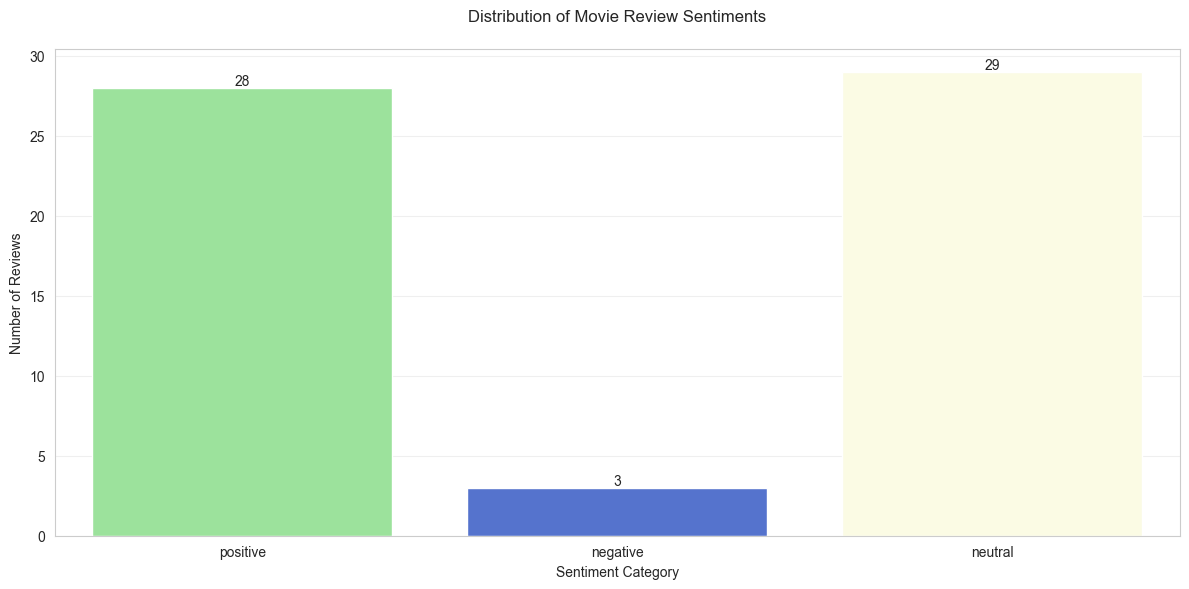


Analysis completed successfully!


In [32]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
import spacy
from docx import Document
import pandas as pd
from textblob import TextBlob
import nltk
from nltk.corpus import wordnet
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

# Ensure nltk resources are downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')

# Contraction patterns to be expanded
contraction_patterns = {
    "doesn't": "does not",
    "didn't": "did not",
    "won't": "will not",
    "can't": "cannot",
    "i'm": "i am",
    "he's": "he is",
    "she's": "she is",
    "they're": "they are",
    "we're": "we are",
    "you're": "you are",
    "it's": "it is",
    "that's": "that is",
    "there's": "there is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "couldn't": "could not",
    "mustn't": "must not",
    "don't": "do not",
}

def expand_contractions(text, contractions_dict):
    """Expand contractions in text based on the provided dictionary."""
    pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')
    expanded_text = pattern.sub(lambda x: contractions_dict[x.group()], text)
    return expanded_text

def read_docx_file(file_path):
    """Read text content from a Word document."""
    try:
        doc = Document(file_path)
        return "\n".join(paragraph.text for paragraph in doc.paragraphs)
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")
        return ""

def get_synonyms(word):
    """Get synonyms for a word using WordNet."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().lower())
    return synonyms

def preprocess_text(text, nlp):
    """Preprocess text with improved cleaning, stop word removal, lemmatization, and synonym filtering."""
    # Expand contractions
    text = expand_contractions(text, contraction_patterns)
    
    # Remove URLs, metadata, and special patterns
    text = re.sub(r'http\S+|www\S+|URL|KEYWORD|IMDB|Author|\d+/\d+|\b\d+\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Remove 'br' tags explicitly
    text = text.replace('br', '')
    
    # Additional metadata and common terms to remove
    metadata_terms = {
        'url', 'keyword', 'author', 'imdb', 'com', 'www', 'http',
        'review', 'movie', 'film', 'rating', 'rated', 'reviews',
        'date', 'plot', 'summary', 'synopsis', 'spoiler', 'spoilers'
    }
    
    # Common movie-related terms that don't indicate sentiment
    movie_terms = {
        'movie', 'film', 'scene', 'character', 'actor', 'actress',
        'director', 'script', 'screenplay', 'production', 'cinema',
        'theater', 'theatre', 'watch', 'watching', 'watched',
        'release', 'released', 'rating', 'rated', 'stars'
    }
    
    # Generic terms that don't add value
    generic_terms = {
        'one', 'two', 'three', 'first', 'second', 'third',
        'way', 'thing', 'something', 'anything', 'everything',
        'many', 'much', 'several', 'few', 'little', 'lot',
        'would', 'could', 'should', 'may', 'might', 'must',
        'get', 'got', 'getting', 'make', 'made', 'making',
        'think', 'thought', 'thinking', 'seem', 'seemed', 'seeming',
        'really', 'actually', 'basically', 'literally', 'definitely'
    }
    
    # Combine all stop words
    all_stop_words = (nlp.Defaults.stop_words
                     .union(ENGLISH_STOP_WORDS)
                     .union(metadata_terms)
                     .union(movie_terms)
                     .union(generic_terms))
    
    # Process with spaCy
    doc = nlp(text.lower())
    lemmatized_tokens = [token.lemma_ for token in doc 
                         if token.lemma_.lower() not in all_stop_words 
                         and token.is_alpha 
                         and len(token.text) > 2]

    # Filter synonyms
    distinct_tokens = []
    seen_synonyms = set()

    for token in lemmatized_tokens:
        token_synonyms = get_synonyms(token)
        if not seen_synonyms.intersection(token_synonyms):
            distinct_tokens.append(token)
            seen_synonyms.update(token_synonyms)
    
    return ' '.join(distinct_tokens)

def get_sentiment_score(text):
    """Calculate sentiment score using TextBlob with error handling."""
    try:
        blob = TextBlob(text)
        return blob.sentiment.polarity
    except Exception as e:
        print(f"Error calculating sentiment: {str(e)}")
        return 0.0

def classify_sentiment(polarity_score):
    """Classify sentiment with more nuanced thresholds."""
    if polarity_score > 0.1:
        return 'positive'
    elif polarity_score < -0.1:
        return 'negative'
    else:
        return 'neutral'

def get_top_words(reviews, sentiment_label, n_features=10):
    """Extract top single words using TF-IDF with improved filtering."""
    if not reviews.any():
        print(f"No reviews found for {sentiment_label} sentiment.")
        return []
    
    # Extended stopwords list specifically for movie reviews
    custom_stopwords = [
        # Basic movie terms
        'movie', 'film', 'review', 'scene', 'character', 'story',
        'plot', 'acting', 'actor', 'actress', 'director', 'script',
        # Metadata terms
        'url', 'keyword', 'author', 'imdb', 'rating', 'rated',
        # Generic terms
        'one', 'two', 'three', 'way', 'time', 'make', 'like',
        'would', 'could', 'should', 'get', 'got', 'see', 'seen',
        'watch', 'watched', 'think', 'thought', 'seem', 'seemed',
        # Common adjectives that don't add value
        'good', 'bad', 'great', 'best', 'worst', 'better', 'worse',
        # Time-related terms
        'year', 'month', 'day', 'time', 'minute', 'hour'
    ]
    
    # Modified TF-IDF vectorizer to only include single terms
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.85,
        min_df=2,
        stop_words=custom_stopwords,
        max_features=n_features,
        ngram_range=(1, 1),  # Changed to (1,1) for single terms only
        token_pattern=r'(?u)\b[a-zA-Z][a-zA-Z]+\b'  # Only match single words
    )
    
    try:
        tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)
        word_scores = tfidf_matrix.sum(axis=0).A1
        terms = tfidf_vectorizer.get_feature_names_out()
        
        # Get top scoring words with minimum threshold
        top_word_indices = np.argsort(word_scores)[::-1]
        top_words = [(terms[i], word_scores[i]) 
                    for i in top_word_indices 
                    if word_scores[i] > 0.5][:n_features]
        
        print(f"\nTop {len(top_words)} single words for {sentiment_label} reviews:")
        for word, score in top_words:
            print(f"{word}: {score:.3f}")
        
        return top_words
    except Exception as e:
        print(f"Error extracting top words: {str(e)}")
        return []

def main():
    # Load spaCy model
    try:
        nlp = spacy.load("en_core_web_sm")
    except OSError:
        print("Downloading spaCy model...")
        os.system("python -m spacy download en_core_web_sm")
        nlp = spacy.load("en_core_web_sm")

    # Read and process documents
    folder_path = r'C:\Users\Raspatel\Downloads\NLP Assignment two\Movie Review'
    documents = []
    filenames = []

    print("Reading documents...")
    for filename in os.listdir(folder_path):
        if filename.endswith(".docx"):
            file_path = os.path.join(folder_path, filename)
            text = read_docx_file(file_path)
            if text:
                documents.append(text)
                filenames.append(filename)
    
    print(f"Processing {len(documents)} documents...")
    
    # Process reviews
    preprocessed_reviews = [preprocess_text(review, nlp) for review in documents]
    sentiment_scores = [get_sentiment_score(review) for review in preprocessed_reviews]

    # Create DataFrame
    sentiment_df = pd.DataFrame({
        'document': filenames,
        'review_text': preprocessed_reviews,
        'sentiment_score': sentiment_scores
    })
    sentiment_df['sentiment'] = sentiment_df['sentiment_score'].apply(classify_sentiment)

    # Display results
    print("\nSentiment Analysis Results:")
    print(sentiment_df[['document', 'sentiment_score', 'sentiment']])

    # Print sentiment distribution
    sentiment_counts = sentiment_df['sentiment'].value_counts()
    print("\nSentiment Distribution:")
    print(sentiment_counts)

    # Analyze word frequencies by sentiment
    for sentiment in ['positive', 'negative', 'neutral']:
        reviews = sentiment_df[sentiment_df['sentiment'] == sentiment]['review_text']
        get_top_words(reviews, sentiment)

    # Create visualization with custom colors
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Custom color palette for sentiments
    color_palette = {
        'positive': '#90EE90',  # Light green
        'negative': '#4169E1',  # Blue
        'neutral': '#FFFFE0'    # Light yellow
    }
    
    # Create the count plot
    ax = sns.countplot(
        data=sentiment_df,
        x='sentiment',
        hue='sentiment',
        palette=color_palette,
        legend=False
    )
    
    plt.title('Distribution of Movie Review Sentiments', pad=20)
    plt.xlabel('Sentiment Category')
    plt.ylabel('Number of Reviews')
    
    # Add value labels on top of bars
    for i in ax.containers:
        ax.bar_label(i)
    
    # Customize the plot
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    
    # Show plot
    plt.show()

    # Print completion message
    print("\nAnalysis completed successfully!")

if __name__ == "__main__":
    main()


### Top Terms and Distribution Across Each Cluster

Preprocessing documents...
Creating TF-IDF matrix...
Performing clustering with 8 clusters...

Silhouette score for 8 clusters: 0.048

Top terms in each cluster:
Cluster 0: joker, musical, feel, film, disappointment, like, character, unexpected, lack, megatron
Cluster 1: reagan, president, dennis, quaid, politic, good, impressive, sourcedate sep, sep url, review movie
Cluster 2: beautiful mind, crowe, russell, john, film, howard, ron, nash, best, illness
Cluster 3: film, bad, like, zombie, willis, web, simply, frank, concert, mess
Cluster 4: deadpool, wolverine, jung, fun, easter, amazing, jackman, reynolds, cinematic, kook
Cluster 5: star, car, computer, film, office, box, davy, kruger, eraser, plot
Cluster 6: nice, beetlejuice, rush, predator, storyline, sequel, original, enjoyable, hearteake, welcome
Cluster 7: good, time, identity, think, mr, seven, film, big, earth, people


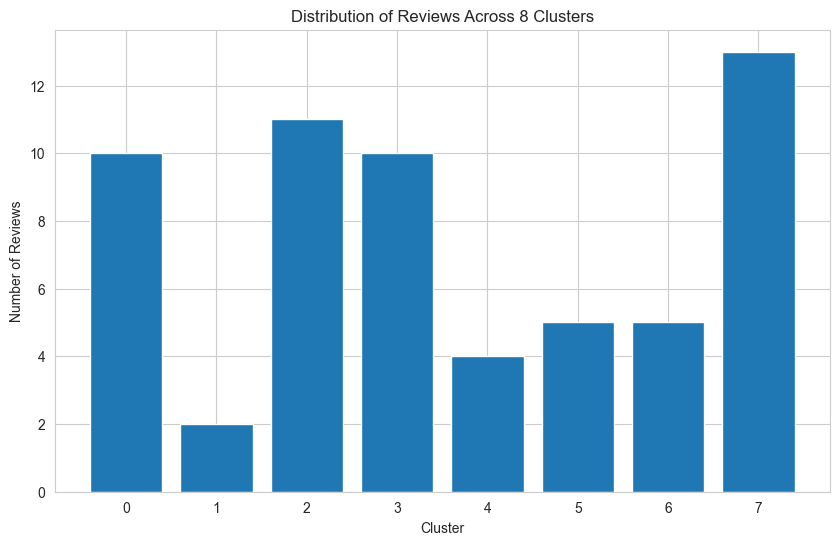

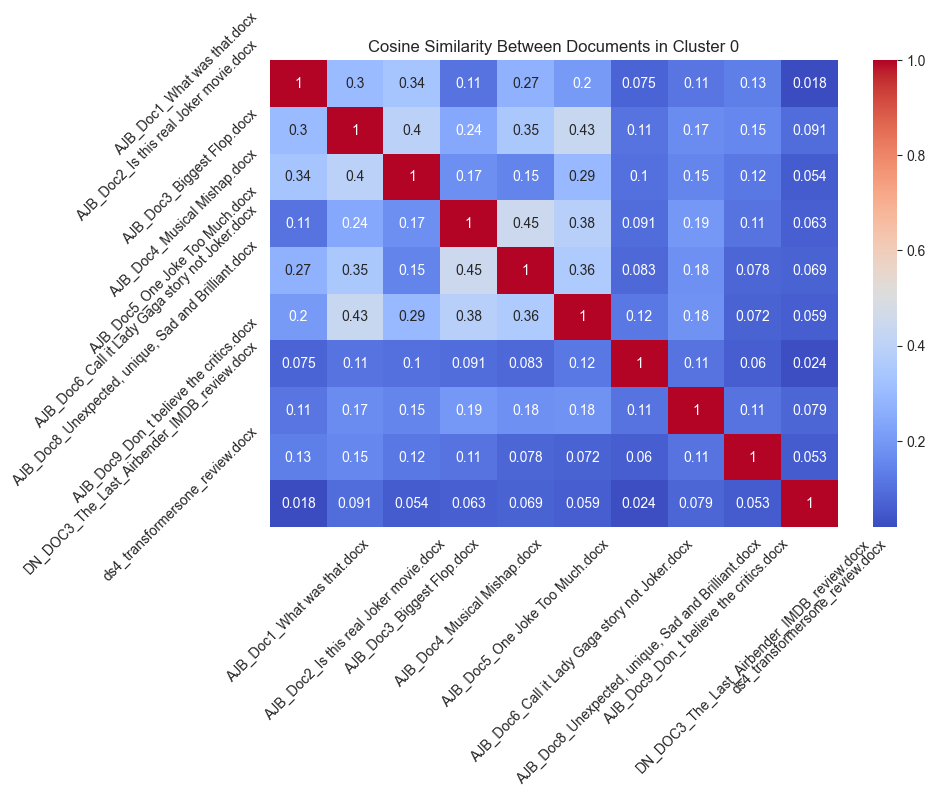

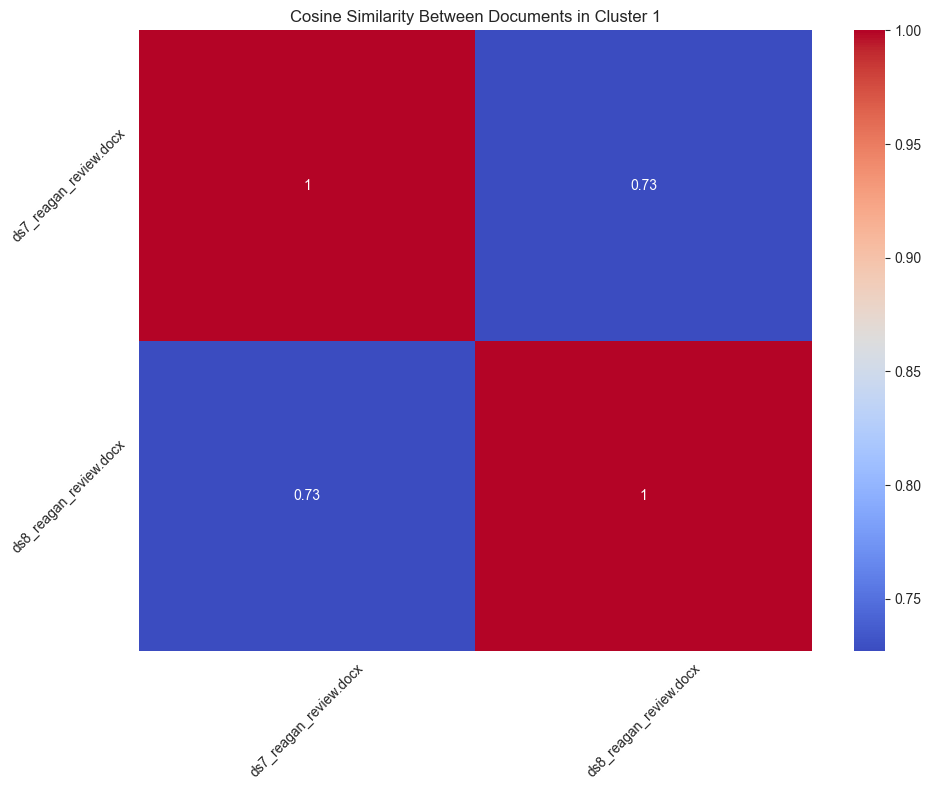

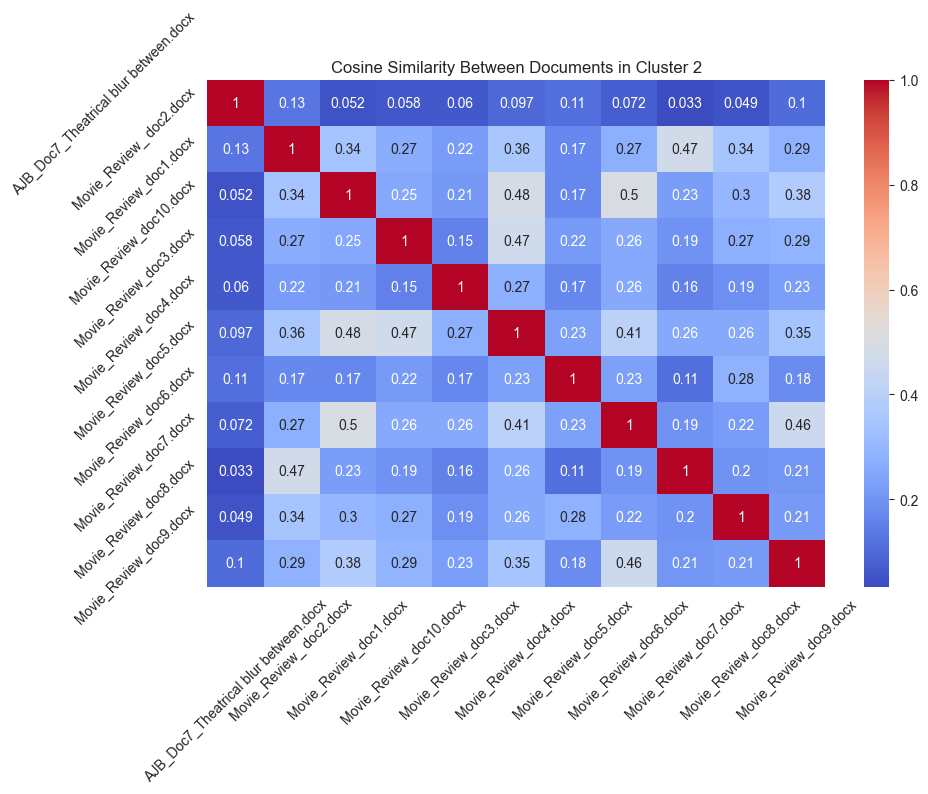

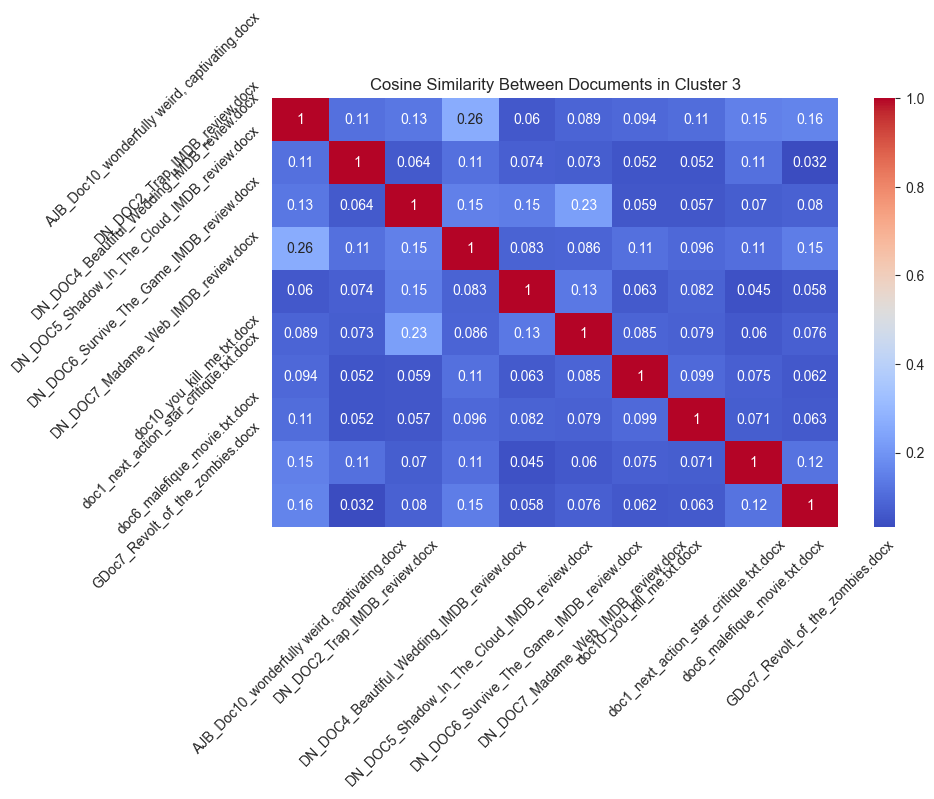

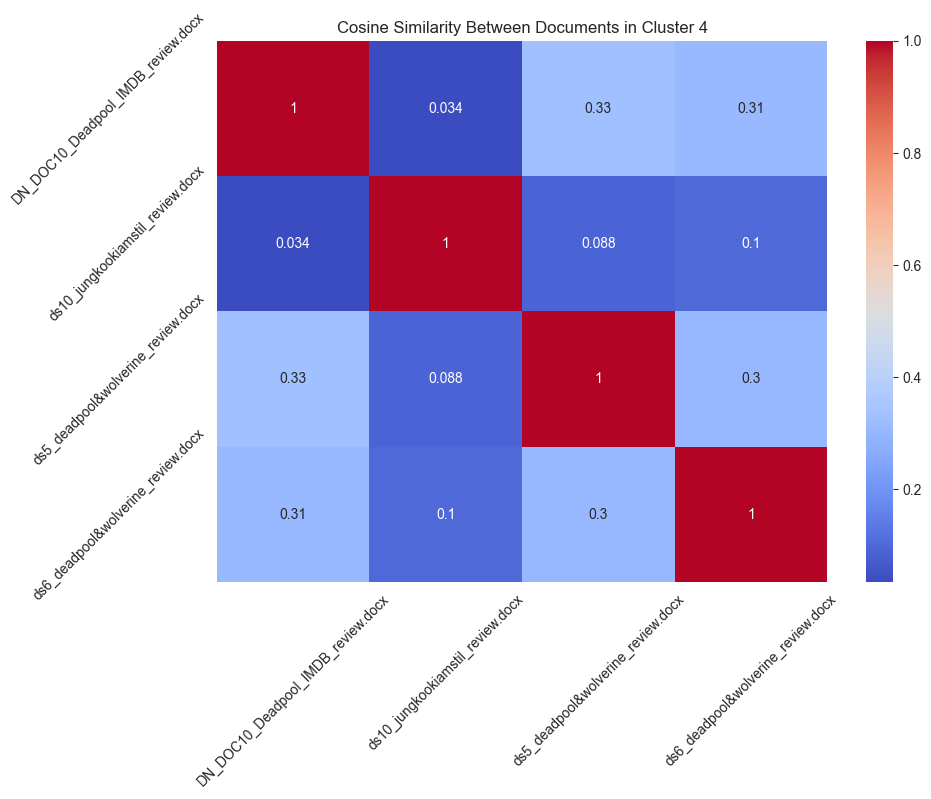

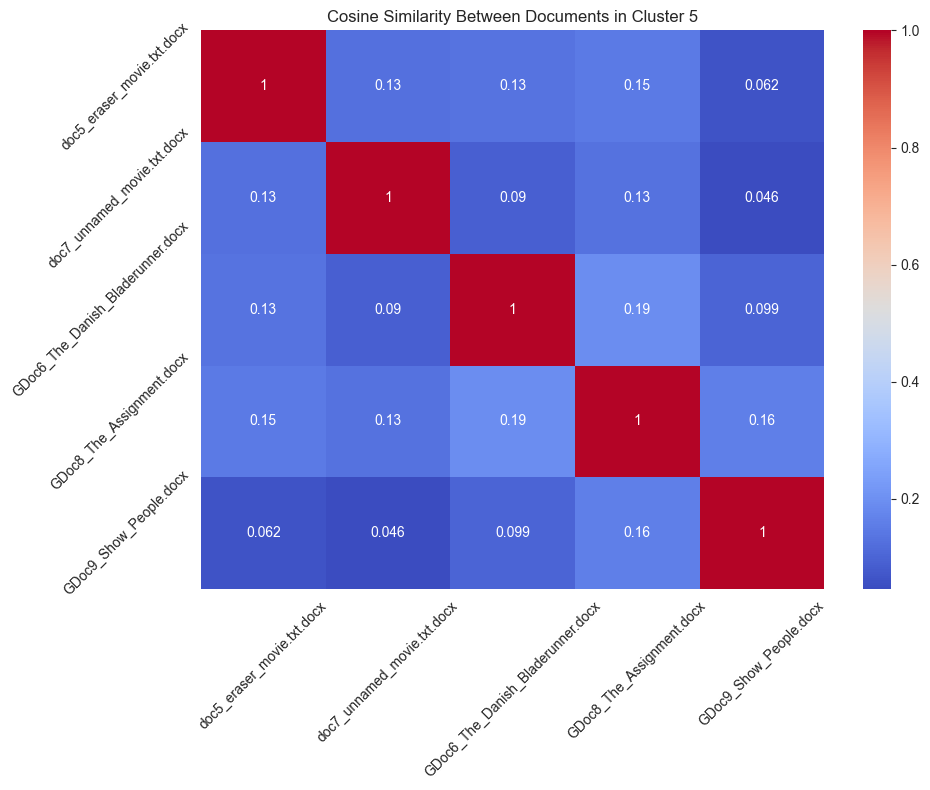

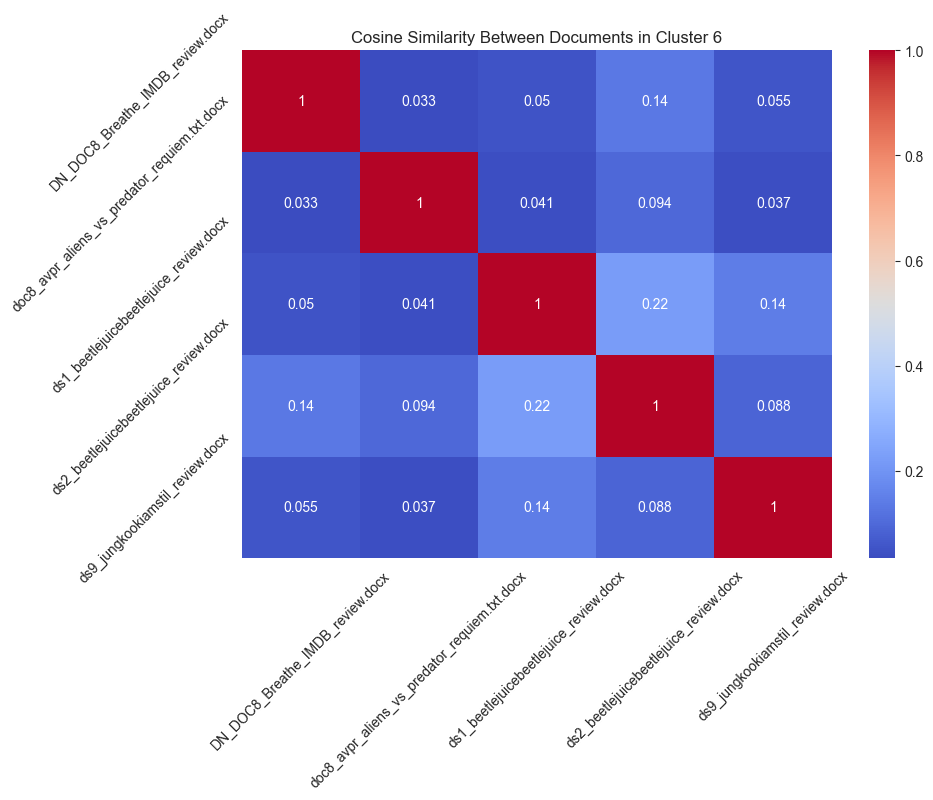

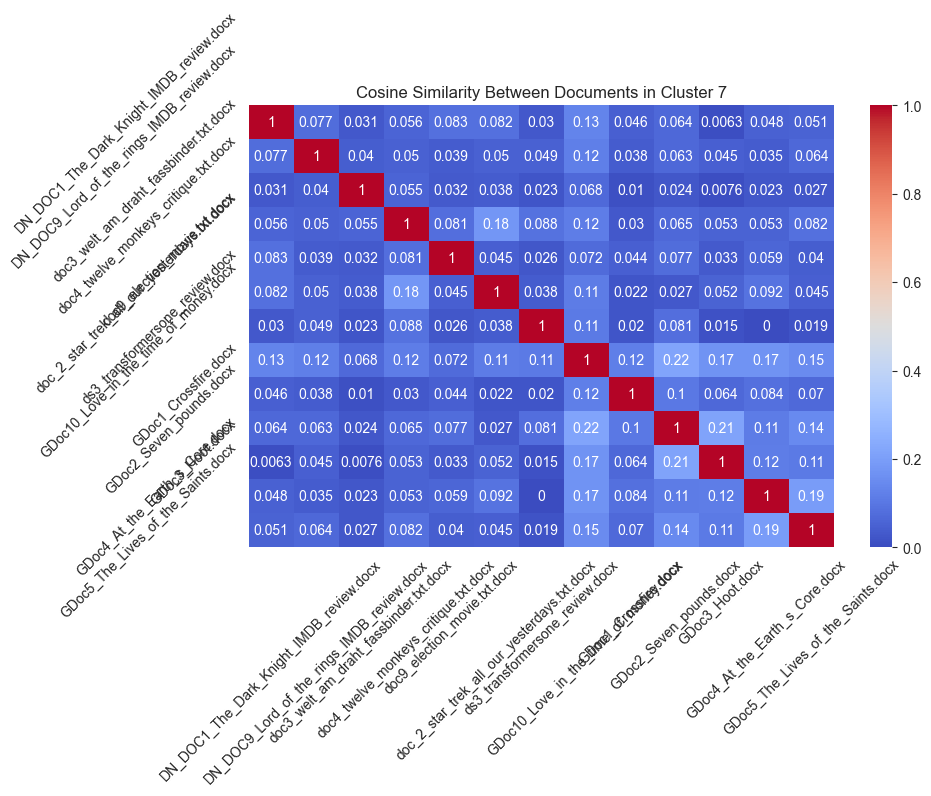

In [34]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import spacy
from docx import Document
import pandas as pd
import warnings

# Disable warnings
warnings.filterwarnings('ignore')
# Disable seaborn specific warnings
import logging
logging.getLogger('seaborn').setLevel(logging.ERROR)

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def read_docx_file(file_path):
    """Read text from a .docx file."""
    doc = Document(file_path)
    full_text = []
    for paragraph in doc.paragraphs:
        full_text.append(paragraph.text)
    return "\n".join(full_text)

def preprocess_text(text):
    """Clean and preprocess text data."""
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove 'br' tags explicitly
    text = text.replace('br', '')
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text, flags=re.MULTILINE)
    # Process with spaCy
    doc = nlp(text)
    # Lemmatization and remove stop words
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

def get_top_terms(cluster_idx, kmeans, terms, n=10):
    """Get top n terms for a given cluster with duplicate removal."""
    cluster_centroid = kmeans.cluster_centers_[cluster_idx]
    sorted_indices = np.argsort(cluster_centroid)[::-1]
    
    # Initialize lists to store unique terms and their scores
    unique_terms = []
    used_substrings = set()
    
    # Iterate through all terms sorted by importance
    for idx in sorted_indices:
        term = terms[idx]
        term_score = cluster_centroid[idx]
        
        # Check if this term is a substring of or contains any previously selected terms
        is_duplicate = False
        for existing_term in used_substrings:
            if term in existing_term or existing_term in term:
                is_duplicate = True
                break
        
        # If it's not a duplicate, add it to our results
        if not is_duplicate:
            unique_terms.append(term)
            used_substrings.add(term)
            
            # Break if we have enough terms
            if len(unique_terms) >= n:
                break
    
    return unique_terms

def main():
    # Step 1: Set up the folder path
    folder_path = r'C:\\Users\\Raspatel\\Downloads\\NLP Assignment two\\Movie Review'
    
    # Step 2: Read documents
    documents = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".docx"):
            file_path = os.path.join(folder_path, filename)
            text = read_docx_file(file_path)
            documents.append(text)
            filenames.append(filename)
    
    # Step 3: Preprocess documents
    print("Preprocessing documents...")
    preprocessed_reviews = [preprocess_text(review) for review in documents]
    
    # Step 4: Create TF-IDF matrix
    print("Creating TF-IDF matrix...")
    tfidf_vectorizer = TfidfVectorizer(
        min_df=1, 
        max_df=0.85, 
        ngram_range=(1, 2), 
        max_features=1000,
        stop_words='english'  # Added explicit stop words removal
    )
    tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_reviews)
    tfidf_matrix_normalized = normalize(tfidf_matrix, norm='l2', axis=1)
    
    # Step 5: Perform clustering
    print("Performing clustering with 8 clusters...")
    kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(tfidf_matrix_normalized)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(tfidf_matrix_normalized, cluster_labels)
    print(f"\nSilhouette score for 8 clusters: {silhouette_avg:.3f}")
    
    # Step 6: Get top terms for each cluster
    terms = tfidf_vectorizer.get_feature_names_out()
    print("\nTop terms in each cluster:")
    for i in range(8):
        top_terms = get_top_terms(i, kmeans, terms)
        print(f"Cluster {i}: {', '.join(top_terms)}")
    
    # Step 7: Create results DataFrame
    movie_reviews = pd.DataFrame({
        'document': filenames,
        'cluster': cluster_labels.astype(int)
    })
    
    # Step 8: Visualize cluster distribution
    plt.figure(figsize=(10, 6))
    cluster_counts = movie_reviews['cluster'].value_counts().sort_index()
    plt.bar(range(8), cluster_counts)
    plt.title('Distribution of Reviews Across 8 Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Reviews')
    plt.xticks(range(8))
    plt.show()
    
    # Step 9: Visualize similarity matrices for each cluster
    cosine_sim = cosine_similarity(tfidf_matrix_normalized)
    for i in range(8):
        cluster_indices = np.where(cluster_labels == i)[0]
        if len(cluster_indices) > 1:
            selected_docs = movie_reviews.iloc[cluster_indices]
            similarity_matrix = cosine_sim[cluster_indices, :][:, cluster_indices]
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', 
                       xticklabels=selected_docs['document'], 
                       yticklabels=selected_docs['document'])
            plt.title(f'Cosine Similarity Between Documents in Cluster {i}')
            plt.xticks(rotation=45)
            plt.yticks(rotation=45)
            plt.tight_layout()
            plt.show()

if __name__ == "__main__":
    main()

### Classification using Doc2Vec 

In [37]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy
from docx import Document
import pandas as pd
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler
import logging

# Suppress Gensim logging completely
logging.getLogger('gensim').setLevel(logging.ERROR)

# Contraction patterns to be expanded
contraction_patterns = {
    "doesn't": "does not",
    "didn't": "did not",
    "won't": "will not",
    "can't": "cannot",
    "i'm": "i am",
    "he's": "he is",
    "she's": "she is",
    "they're": "they are",
    "we're": "we are",
    "you're": "you are",
    "it's": "it is",
    "that's": "that is",
    "there's": "there is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "couldn't": "could not",
    "mustn't": "must not",
    "don't": "do not",
}

def expand_contractions(text, contractions_dict):
    """Expand contractions in text based on the provided dictionary."""
    pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')
    expanded_text = pattern.sub(lambda x: contractions_dict[x.group()], text)
    return expanded_text

def preprocess_text(text, nlp):
    """Preprocess text: expand contractions, remove unwanted patterns, and lemmatize."""
    # Expand contractions
    text = expand_contractions(text, contraction_patterns)
    # Remove URLs and unwanted patterns
    text = re.sub(r'http\S+|www\S+|URL|KEYWORD|IMDB|Author|\d+/\d+|\b\d+\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = text.replace('br', '')

    # Process text with spaCy
    doc = nlp(text.lower())
    
    # Lemmatize and remove stopwords
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha and len(token) > 2]
    
    return ' '.join(tokens)

def get_sentiment_score(text):
    """Calculate sentiment score using TextBlob."""
    try:
        blob = TextBlob(text)
        return blob.sentiment.polarity
    except Exception as e:
        print(f"Error calculating sentiment: {str(e)}")
        return 0.0

def classify_sentiment(polarity_score):
    """Classify sentiment based on polarity score thresholds."""
    if polarity_score > 0.1:
        return 'positive'
    elif polarity_score < -0.1:
        return 'negative'
    else:
        return 'neutral'

# Load dataset
def load_documents(folder_path: str):
    """Load documents from a folder and handle encoding errors."""
    documents = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".docx"):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                    text = file.read()
                    documents.append(text)
                    filenames.append(filename)
            except UnicodeDecodeError:
                with open(file_path, 'r', encoding='ISO-8859-1', errors='ignore') as file:
                    text = file.read()
                    documents.append(text)
                    filenames.append(filename)
    return documents, filenames

# Train the Doc2Vec model
def train_doc2vec_model(preprocessed_documents):
    """Train a Doc2Vec model on preprocessed documents."""
    tagged_documents = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(preprocessed_documents)]
    model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=20)
    model.build_vocab(tagged_documents)
    model.train(tagged_documents, total_examples=model.corpus_count, epochs=model.epochs)
    return model

# Train and evaluate classifiers (Logistic Regression, GaussianNB, and MultinomialNB)
def train_and_evaluate_classifiers(doc_vectors, labels):
    """Train and evaluate classifiers using Logistic Regression, GaussianNB, and MultinomialNB."""
    
    # Normalize doc_vectors to non-negative values for MultinomialNB
    scaler = MinMaxScaler()
    doc_vectors_normalized = scaler.fit_transform(doc_vectors)

    X_train, X_test, y_train, y_test = train_test_split(doc_vectors, labels, test_size=0.2, random_state=42)

    # Logistic Regression
    lr_model = LogisticRegression(max_iter=200)
    lr_model.fit(X_train, y_train)
    lr_y_pred = lr_model.predict(X_test)
    
    # Gaussian Naive Bayes (can handle negative values)
    nb_gaussian_model = GaussianNB()
    nb_gaussian_model.fit(X_train, y_train)
    nb_gaussian_y_pred = nb_gaussian_model.predict(X_test)

    # Train Multinomial Naive Bayes with normalized document vectors
    X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(doc_vectors_normalized, labels, test_size=0.2, random_state=42)
    nb_multinomial_model = MultinomialNB()
    nb_multinomial_model.fit(X_train_norm, y_train_norm)
    nb_multinomial_y_pred = nb_multinomial_model.predict(X_test_norm)

    # Evaluate all models
    evaluate_model("Logistic Regression", y_test, lr_y_pred)
    evaluate_model("Gaussian Naive Bayes", y_test, nb_gaussian_y_pred)
    evaluate_model("Multinomial Naive Bayes (Normalized)", y_test_norm, nb_multinomial_y_pred)

def evaluate_model(model_name, y_test, y_pred):
    """Evaluate the model and print metrics."""
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
    report = classification_report(y_test, y_pred, zero_division=1)

    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Classification Report:\n{report}")

def main():
    """Main function to run Doc2Vec model training, sentiment analysis, and classification."""
    # Load spaCy model
    try:
        nlp = spacy.load("en_core_web_sm")
    except OSError:
        print("Downloading spaCy model...")
        os.system("python -m spacy download en_core_web_sm")
        nlp = spacy.load("en_core_web_sm")

    # Folder path for movie reviews
    folder_path = r'C:\Users\Raspatel\Downloads\NLP Assignment two\Movie Review'

    # Load and preprocess documents
    documents, filenames = load_documents(folder_path)
    preprocessed_reviews = [preprocess_text(review, nlp) for review in documents]
    
    # Sentiment analysis
    sentiment_scores = [get_sentiment_score(review) for review in preprocessed_reviews]
    sentiments = [classify_sentiment(score) for score in sentiment_scores]
    labels = [1 if sentiment == 'positive' else -1 if sentiment == 'negative' else 0 for sentiment in sentiments]

    # Train Doc2Vec model
    doc2vec_model = train_doc2vec_model(preprocessed_reviews)

    # Get document vectors from the trained model
    doc_vectors = np.array([doc2vec_model.dv[str(i)] for i in range(len(preprocessed_reviews))])

    # Train and evaluate classifiers (Logistic Regression, GaussianNB, MultinomialNB)
    train_and_evaluate_classifiers(doc_vectors, labels)

if __name__ == "__main__":
    main()



Logistic Regression Performance:
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.88
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.00      0.00         1
           0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.96      0.50      0.48        12
weighted avg       0.92      0.92      0.88        12


Gaussian Naive Bayes Performance:
Accuracy: 0.83
Precision: 0.92
Recall: 0.83
F1 Score: 0.83
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.00      0.00         1
           0       0.91      0.91      0.91        11
           1       0.00      1.00      0.00         0

    accuracy                           0.83        12
   macro avg       0.64      0.64      0.30        12
weighted avg       0.92      0.83      0.83        12


Multinomial Naive Bayes (Normalized) Performance:
Accuracy

### Classification Using TF-IDF

In [59]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from docx import Document
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler
import logging

# Suppress logging
logging.getLogger('gensim').setLevel(logging.ERROR)

# Contraction patterns to be expanded
contraction_patterns = {
    "doesn't": "does not",
    "didn't": "did not",
    "won't": "will not",
    "can't": "cannot",
    "i'm": "i am",
    "he's": "he is",
    "she's": "she is",
    "they're": "they are",
    "we're": "we are",
    "you're": "you are",
    "it's": "it is",
    "that's": "that is",
    "there's": "there is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "couldn't": "could not",
    "mustn't": "must not",
    "don't": "do not",
}

def expand_contractions(text, contractions_dict):
    """Expand contractions in text based on the provided dictionary."""
    pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')
    expanded_text = pattern.sub(lambda x: contractions_dict[x.group()], text)
    return expanded_text

def preprocess_text(text, nlp):
    """Preprocess text: expand contractions, remove unwanted patterns, and lemmatize."""
    # Expand contractions
    text = expand_contractions(text, contraction_patterns)
    # Remove URLs and unwanted patterns
    text = re.sub(r'http\S+|www\S+|URL|KEYWORD|IMDB|Author|\d+/\d+|\b\d+\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = text.replace('br', '')

    # Process text with spaCy
    doc = nlp(text.lower())
    
    # Lemmatize and remove stopwords
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha and len(token) > 2]
    
    return ' '.join(tokens)

def get_sentiment_score(text):
    """Calculate sentiment score using TextBlob."""
    try:
        blob = TextBlob(text)
        return blob.sentiment.polarity
    except Exception as e:
        print(f"Error calculating sentiment: {str(e)}")
        return 0.0

def classify_sentiment(polarity_score):
    """Classify sentiment based on polarity score thresholds."""
    if polarity_score > 0.1:
        return 'positive'
    elif polarity_score < -0.1:
        return 'negative'
    else:
        return 'neutral'

# Load dataset
def load_documents(folder_path: str):
    """Load documents from a folder and handle encoding errors."""
    documents = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".docx"):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                    text = file.read()
                    documents.append(text)
                    filenames.append(filename)
            except UnicodeDecodeError:
                with open(file_path, 'r', encoding='ISO-8859-1', errors='ignore') as file:
                    text = file.read()
                    documents.append(text)
                    filenames.append(filename)
    return documents, filenames

# Train and evaluate classifiers (Logistic Regression, GaussianNB, and MultinomialNB)
def train_and_evaluate_classifiers(doc_vectors, labels):
    """Train and evaluate classifiers using Logistic Regression, GaussianNB, and MultinomialNB."""
    
    # Normalize doc_vectors to non-negative values for MultinomialNB
    scaler = MinMaxScaler()
    doc_vectors_normalized = scaler.fit_transform(doc_vectors)

    X_train, X_test, y_train, y_test = train_test_split(doc_vectors, labels, test_size=0.2, random_state=42)

    # Logistic Regression
    lr_model = LogisticRegression(max_iter=200)
    lr_model.fit(X_train, y_train)
    lr_y_pred = lr_model.predict(X_test)
    
    # Gaussian Naive Bayes (can handle negative values)
    nb_gaussian_model = GaussianNB()
    nb_gaussian_model.fit(X_train, y_train)
    nb_gaussian_y_pred = nb_gaussian_model.predict(X_test)

    # Train Multinomial Naive Bayes with normalized document vectors
    X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(doc_vectors_normalized, labels, test_size=0.2, random_state=42)
    nb_multinomial_model = MultinomialNB()
    nb_multinomial_model.fit(X_train_norm, y_train_norm)
    nb_multinomial_y_pred = nb_multinomial_model.predict(X_test_norm)

    # Evaluate all models
    evaluate_model("Logistic Regression", y_test, lr_y_pred)
    evaluate_model("Gaussian Naive Bayes", y_test, nb_gaussian_y_pred)
    evaluate_model("Multinomial Naive Bayes (Normalized)", y_test_norm, nb_multinomial_y_pred)

def evaluate_model(model_name, y_test, y_pred):
    """Evaluate the model and print metrics."""
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
    report = classification_report(y_test, y_pred, zero_division=1)

    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Classification Report:\n{report}")

def main():
    """Main function to run TF-IDF vectorization, sentiment analysis, and classification."""
    # Load spaCy model
    try:
        nlp = spacy.load("en_core_web_sm")
    except OSError:
        print("Downloading spaCy model...")
        os.system("python -m spacy download en_core_web_sm")
        nlp = spacy.load("en_core_web_sm")

    # Folder path for movie reviews
    folder_path = r'C:\Users\Raspatel\Downloads\NLP Assignment two\Movie Review'

    # Load and preprocess documents
    documents, filenames = load_documents(folder_path)
    preprocessed_reviews = [preprocess_text(review, nlp) for review in documents]
    
    # Sentiment analysis
    sentiment_scores = [get_sentiment_score(review) for review in preprocessed_reviews]
    sentiments = [classify_sentiment(score) for score in sentiment_scores]
    labels = [1 if sentiment == 'positive' else -1 if sentiment == 'negative' else 0 for sentiment in sentiments]

    # Vectorize using TF-IDF
    vectorizer = TfidfVectorizer(max_features=1000)  # Adjust the number of features as needed
    doc_vectors = vectorizer.fit_transform(preprocessed_reviews).toarray()

    # Train and evaluate classifiers (Logistic Regression, GaussianNB, MultinomialNB)
    train_and_evaluate_classifiers(doc_vectors, labels)

if __name__ == "__main__":
    main()



Logistic Regression Performance:
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.88
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.00      0.00         1
           0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.96      0.50      0.48        12
weighted avg       0.92      0.92      0.88        12


Gaussian Naive Bayes Performance:
Accuracy: 0.83
Precision: 0.92
Recall: 0.83
F1 Score: 0.83
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.00      0.00         1
           0       0.91      0.91      0.91        11
           1       0.00      1.00      0.00         0

    accuracy                           0.83        12
   macro avg       0.64      0.64      0.30        12
weighted avg       0.92      0.83      0.83        12


Multinomial Naive Bayes (Normalized) Performance:
Accuracy

### Insight
To check the performance of both TF-IDF and Doc2Vec used both.
TF-IDF provides strong performance with simpler models like Logistic Regression but struggles with Naive Bayes, especially Multinomial Naive Bayes.
Doc2Vec offers comparable or slightly better performance in models like Logistic Regression and Multinomial Naive Bayes, making it a preferable choice
